In [96]:
import time
from datetime import datetime
import vectorbt as vbt
from tqdm import tqdm

import pandas as pd
import pandas_ta as ta
import numpy as np
import mplfinance as mpf

from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

### Stochastic Osillator
- อธิบายส่วนประกอบ indicator
    - %K มีค่า 0-100
    - %D คือ moving average ของ %K
    - smooth_k ไว้ถ่วงน้ำหนัก %K
    - %K > 80 คือ overbought
    - %K < 20 คือ oversold
- ตัวอย่างใช้งาน
    - ใช้งานหาจุดย่อ
    - เข้าเมื่อราคา overbought/oversold
    - เข้าเมื่อราคา overbought/oversold แล้วกลับมาในช่วงปกติ
    - เข้าเมื่อ %K และ %D ตัดกันในช่วง overbought/oversold
    - ใช้กับกราฟมีเทรน
    - ใช้กับกราฟเสียเทรน
    - ใช้กับกราฟ sideway
    - divergence
- เปรียบเทียบจุดแข็งจุดอ่อน
- วิธีแก้ไข

##### ที่มา

https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/stochastic-oscillator/

https://fbs.com/analytics/guidebooks/stochastic-49

https://knowledge.bualuang.co.th/knowledge-base/stochastic-oscillator/

https://admiralmarkets.sc/th/education/articles/forex-indicators/trading-stochastic-oscillator

https://www.lucid-trader.com/stochastic-oscillator/

https://www.blockdit.com/posts/62032a3baf49dfef96510232

In [151]:
data = pd.read_csv('../MyStrategy/GBPUSD_1h.csv')
data.tail()

timestamp      open      high       low     close  \
5011  2022-08-30 13:00:00+01:00  1.171921  1.172044  1.169098  1.170029   
5012  2022-08-30 14:00:00+01:00  1.169892  1.171921  1.169180  1.169905   
5013  2022-08-30 15:00:00+01:00  1.168484  1.168484  1.162372  1.162926   
5014  2022-08-30 16:00:00+01:00  1.163399  1.167174  1.163399  1.165189   
5015  2022-08-30 17:00:00+01:00  1.165365  1.166521  1.164985  1.165189   

      adj close  volumn  
5011   1.170029       0  
5012   1.169905       0  
5013   1.162926       0  
5014   1.165189       0  
5015   1.165189       0

In [152]:
df = data.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_localize(None)
df.set_index('timestamp', inplace = True)
df

open      high       low     close  adj close  volumn
timestamp                                                                     
2021-11-04 17:00:00  1.349364  1.349437  1.348418  1.349273   1.349273       0
2021-11-04 18:00:00  1.349382  1.350366  1.349091  1.349655   1.349655       0
2021-11-04 19:00:00  1.349509  1.350475  1.349509  1.350238   1.350238       0
2021-11-04 20:00:00  1.350311  1.350457  1.349509  1.350020   1.350020       0
2021-11-04 21:00:00  1.349692  1.350202  1.348745  1.350074   1.350074       0
...                       ...       ...       ...       ...        ...     ...
2022-08-30 12:00:00  1.171921  1.172044  1.169098  1.170029   1.170029       0
2022-08-30 13:00:00  1.169892  1.171921  1.169180  1.169905   1.169905       0
2022-08-30 14:00:00  1.168484  1.168484  1.162372  1.162926   1.162926       0
2022-08-30 15:00:00  1.163399  1.167174  1.163399  1.165189   1.165189       0
2022-08-30 16:00:00  1.165365  1.166521  1.164985  1.165189   1.165189       0

[5016 rows x 6 columns]

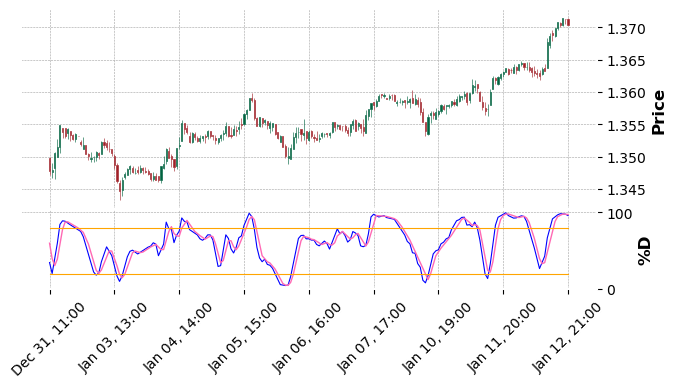

In [159]:
df.ta.stoch(14, append=True) # default k=14, d=3, smooth_k=3
df['prev_k'] = df['STOCHk_14_3_3'].shift(1)
df['prev_d'] = df['STOCHd_14_3_3'].shift(1)
df['d_cross'] = (df['prev_k'] > df['prev_d']) & (df['STOCHk_14_3_3'] < df['STOCHd_14_3_3'])
df['k_cross'] = (df['prev_k'] < df['prev_d']) & (df['STOCHk_14_3_3'] > df['STOCHd_14_3_3']) 

start_date, end_date = '2021-12-31 10:45:00', '2022-01-12 21:45:00'

stoch_k = df['STOCHk_14_3_3'].loc[start_date: end_date]
stoch_d = df['STOCHd_14_3_3'].loc[start_date: end_date]
df_plot = df.loc[start_date: end_date]

overbought = np.empty(df_plot.shape[0])
overbought.fill(80)
oversold = np.empty(df_plot.shape[0])
oversold.fill(20)

k_plot = mpf.make_addplot(stoch_k, panel=1, color='blue', width=0.8, ylabel='%K')
d_plot = mpf.make_addplot(stoch_d, panel=1, color='hotpink', width=1, ylabel='%D')
overbought_plot = mpf.make_addplot(overbought, panel=1, color='orange', width=0.8)
oversold_plot = mpf.make_addplot(oversold, panel=1, color='orange', width=0.8)

mpf.plot(df_plot, type='candle', style='charles',
         addplot=[k_plot, d_plot, overbought_plot, oversold_plot],
         figsize=(8, 4))

In [166]:
# - เข้าเมื่อราคา overbought/oversold
# - เข้าเมื่อราคา overbought/oversold แล้วกลับมาในช่วงปกติ
# - เข้าเมื่อ %K และ %D ตัดกันในช่วง overbought/oversold
# แบบไหนได้ราคาสูงสุด ต่ำสุด ? ถ้าเข้าที่ open ค่า stoch k=14, d=3, smooth_k=3

def find_peak_price(df, entry_type='open'):
    entry_data = dict(entry_start=[0, 0], entry_end=[0, 0], entry_cross=[0, 0])
    start_index = 0
    end_index = 0
    current_min_prices = [np.Inf, np.Inf, np.Inf]
    current_max_prices = [np.NINF, np.NINF, np.NINF]
    is_crossed = False
    df_status = 'idle'

    for index, row in df.iterrows():
        if df_status == 'idle':
            if row['STOCHk_14_3_3'] > 80:
                df_status = 'overbought'
                current_max_prices[0] = row[entry_type]

            elif row['STOCHk_14_3_3'] < 20:
                df_status = 'oversold'
                current_min_prices[0] = row[entry_type]

        if df_status == 'overbought':
            if row['d_cross'] == True and is_crossed == False:
                is_crossed = True
                current_max_prices[1] = row[entry_type]

            if row['STOCHk_14_3_3'] < 80:
                df_status = 'idle'
                is_crossed = False
                current_max_prices[2] = row[entry_type]

                max_item = max(current_max_prices)
                index_list = [index for index in range(len(current_max_prices)) if current_max_prices[index] == max_item]
                # print(index_list)
                for i in index_list:
                    if i == 0:
                        entry_data['entry_start'][0] = entry_data['entry_start'][0] + 1
                    elif i == 1:
                        entry_data['entry_cross'][0] = entry_data['entry_cross'][0] + 1
                    elif i == 2:
                        entry_data['entry_end'][0] = entry_data['entry_end'][0] + 1
                # print('max: ', max_item, current_max_prices.index(max_item))
                current_max_prices = [np.NINF, np.NINF, np.NINF]

        if df_status == 'oversold':
            if row['k_cross'] == True and is_crossed == False:
                is_crossed = True
                current_min_prices[1] = row[entry_type]

            if row['STOCHk_14_3_3'] > 20:
                df_status = 'idle'
                is_crossed = False
                current_min_prices[2] = row[entry_type]

                min_item = min(current_min_prices)
                index_list = [index for index in range(len(current_min_prices)) if current_min_prices[index] == min_item]
                # print(index_list)
                for i in index_list:
                    if i == 0:
                        entry_data['entry_start'][1] = entry_data['entry_start'][1] + 1
                    elif i == 1:
                        entry_data['entry_cross'][1] = entry_data['entry_cross'][1] + 1
                    elif i == 2:
                        entry_data['entry_end'][1] = entry_data['entry_end'][1] + 1
                # print('min: ', min_item, current_min_prices.index(min_item))
                current_min_prices = [np.Inf, np.Inf, np.Inf]

    return [entry_data['entry_start'], entry_data['entry_end'], entry_data['entry_cross']]


In [169]:
open_peak_prices = find_peak_price(df.copy(), entry_type='open')
bar = vbt.plotting.Bar(
    data=open_peak_prices,
    trace_names=['overbought', 'oversold'],
    x_labels=['entry start', 'entry end', '%K %D cross']
)
bar.fig


FigureWidget({
    'data': [{'name': 'overbought',
              'showlegend': True,
              'type': 'ba…

In [115]:
close_peak_prices = find_peak_price(df.copy(), entry_type='close')
bar = vbt.plotting.Bar(
    data=close_peak_prices,
    trace_names=['overbought', 'oversold'],
    x_labels=['entry start', 'entry end', '%K %D cross']
)
bar.fig

FigureWidget({
    'data': [{'name': 'overbought',
              'showlegend': True,
              'type': 'ba…

In [157]:
def stoch_plot(df, start, end, plot_cross=True):
    df_plot = df.iloc[start: end]
    stoch_k = df_plot['STOCHk_14_3_3']
    stoch_d = df_plot['STOCHd_14_3_3']

    overbought = np.empty(df_plot.shape[0])
    overbought.fill(80)
    oversold = np.empty(df_plot.shape[0])
    oversold.fill(20)

    k_plot = mpf.make_addplot(stoch_k, panel=1, color='blue', width=0.8, ylabel='%K')
    d_plot = mpf.make_addplot(stoch_d, panel=1, color='hotpink', width=1, ylabel='%D')
    overbought_plot = mpf.make_addplot(overbought, panel=1, color='orange', width=0.8)
    oversold_plot = mpf.make_addplot(oversold, panel=1, color='orange', width=0.8)

    if plot_cross == False:
        return [k_plot, d_plot, overbought_plot, oversold_plot]

    up_markers = []
    down_markers = []

    for index, row in df_plot.iterrows():
        d_cross = row['d_cross']
        k_cross = row['k_cross']
        if k_cross == True and row['STOCHk_14_3_3'] < 20:
            up_markers.append(row['low'] * 0.998)
            down_markers.append(np.nan)
        elif d_cross == True and row['STOCHk_14_3_3'] > 80:
            up_markers.append(np.nan)
            down_markers.append(row['high'] * 1.002)
        else:
            up_markers.append(np.nan)
            down_markers.append(np.nan)

    up_plot = mpf.make_addplot(up_markers, type='scatter', marker='^', markersize=10, panel=0, color='red')
    down_plot = mpf.make_addplot(down_markers, type='scatter', marker='v', markersize=10, panel=0, color='green')

    return [k_plot, d_plot, overbought_plot, oversold_plot, up_plot, down_plot]

In [132]:
stoch_info_plots = stoch_plot(df, 0, 264)

mpf.plot(df.iloc[0:264], type='candle', style='charles',
         addplot=stoch_info_plots,
         figsize=(10, 6))

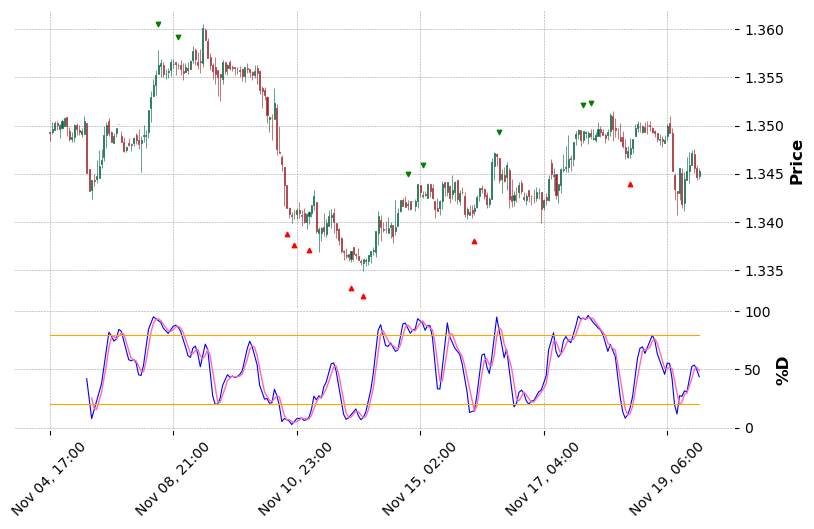

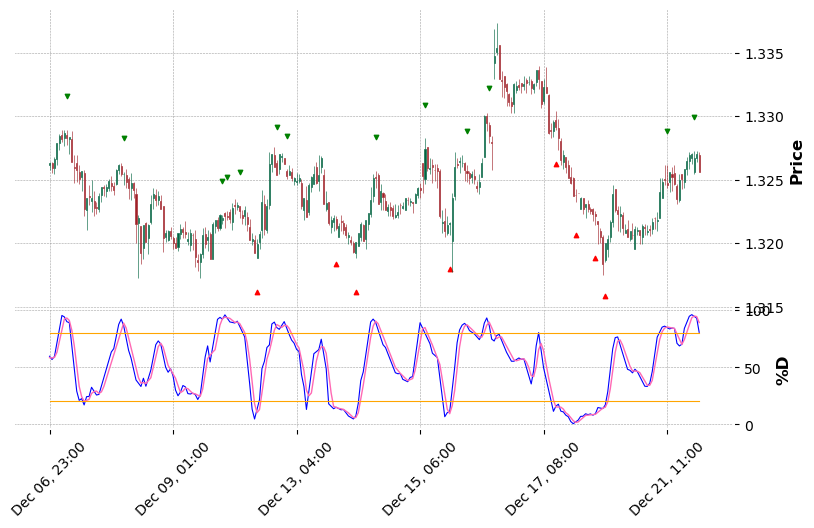

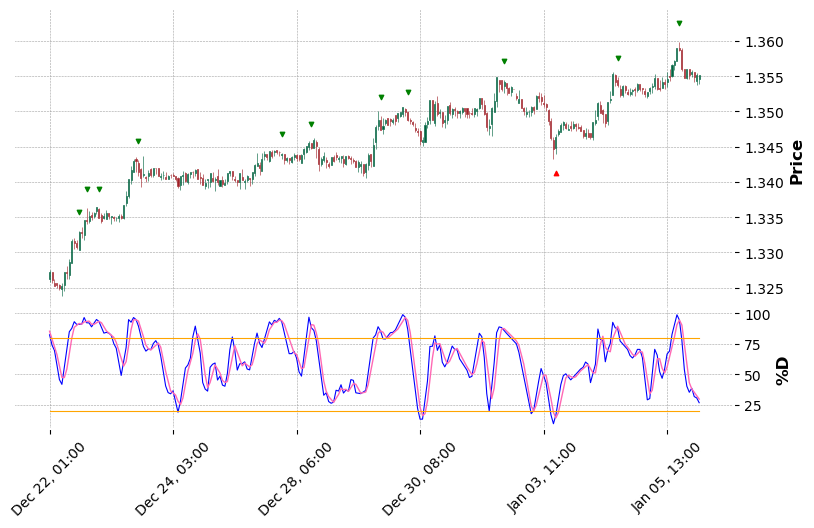

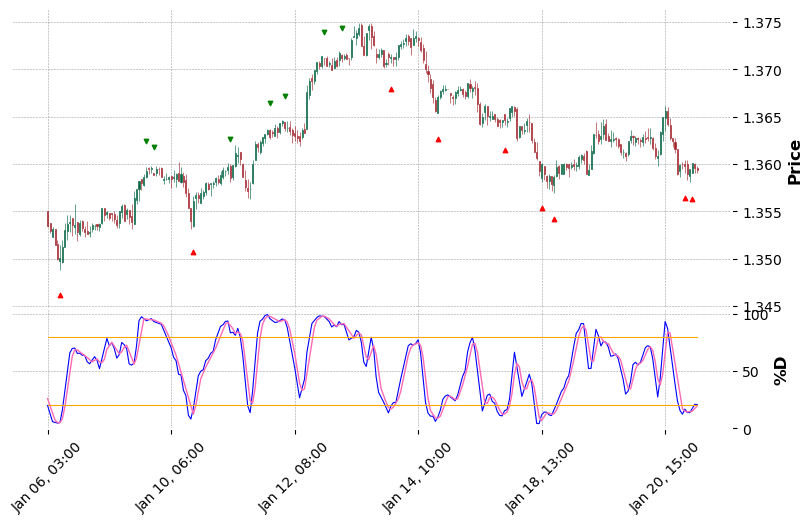

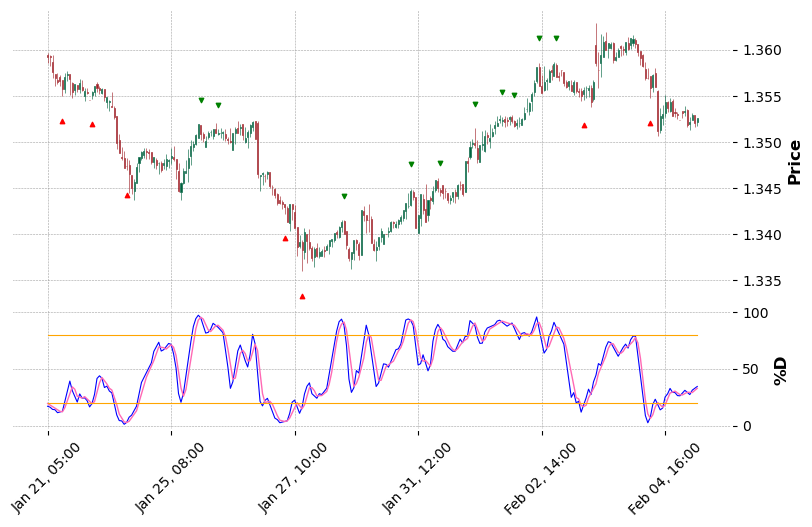

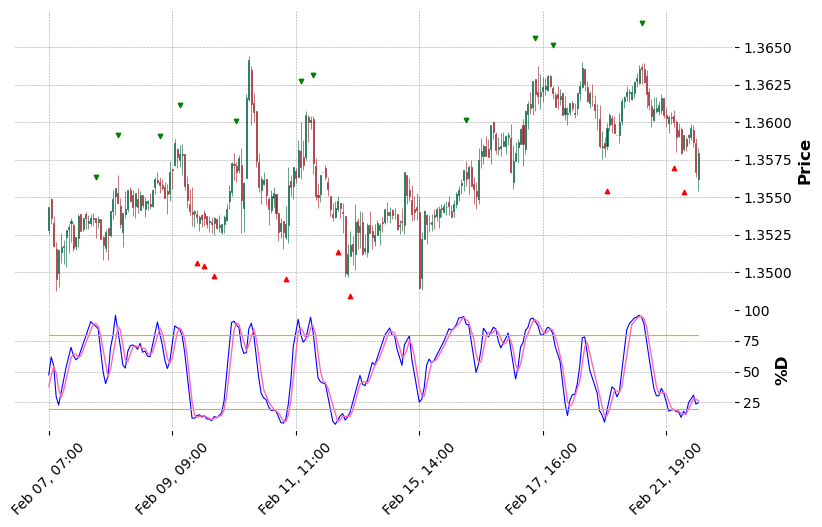

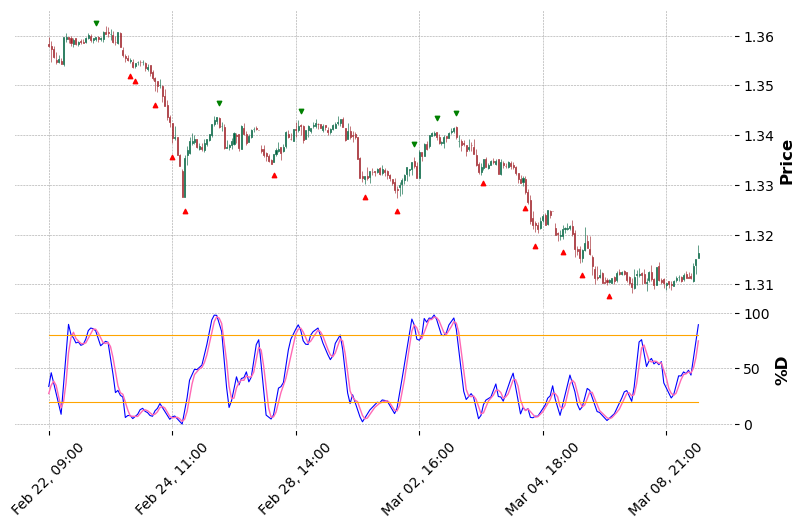

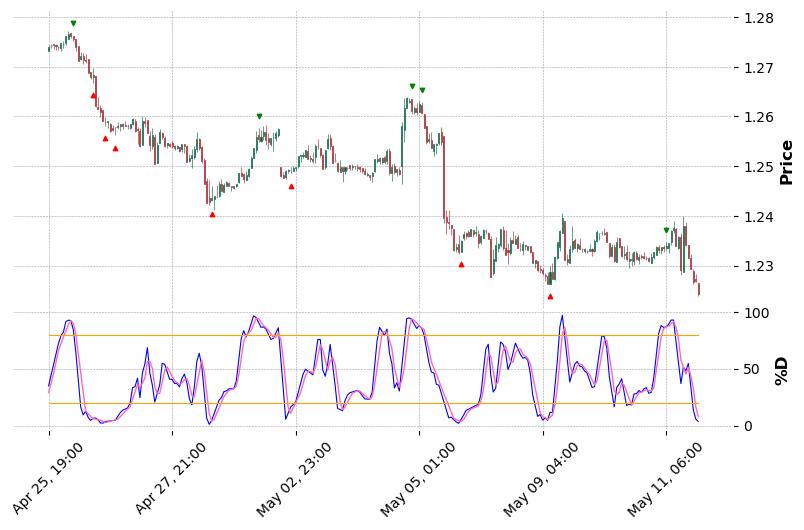

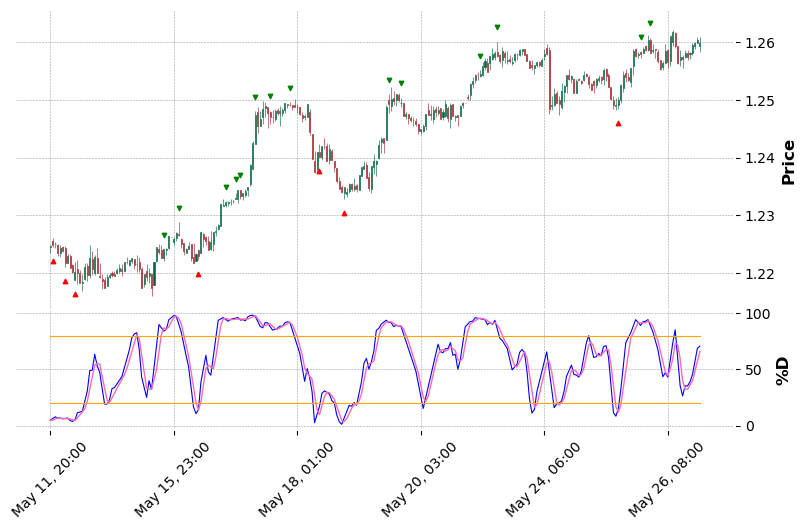

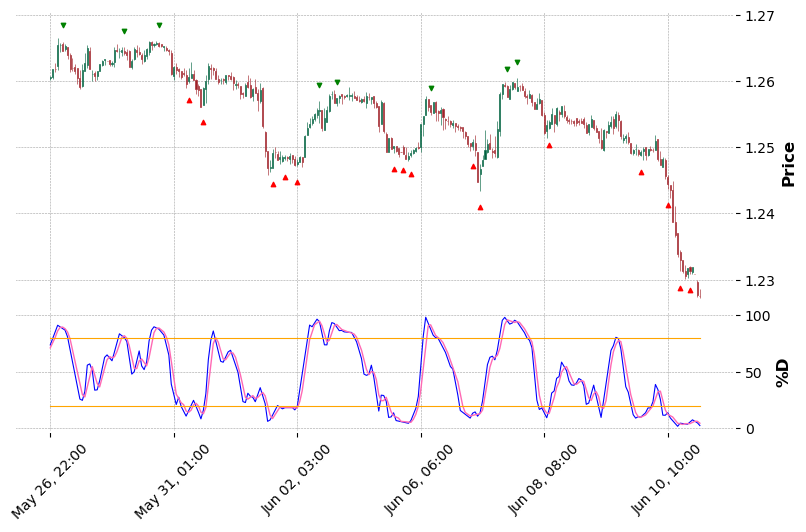

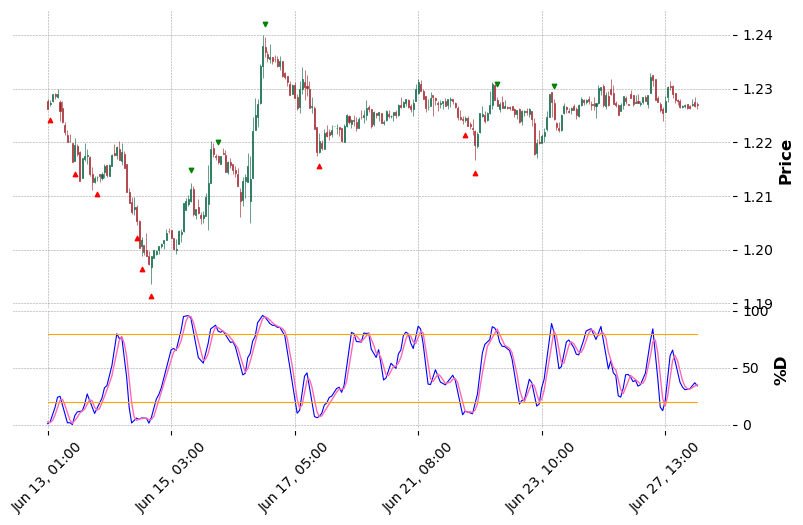

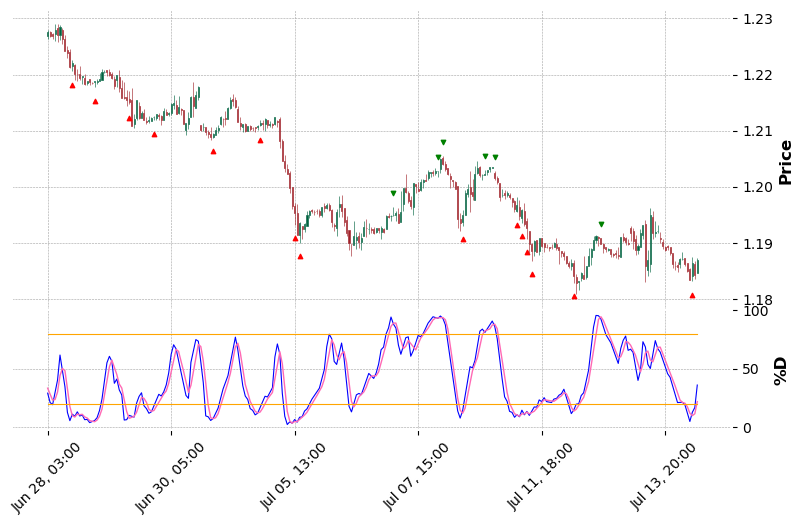

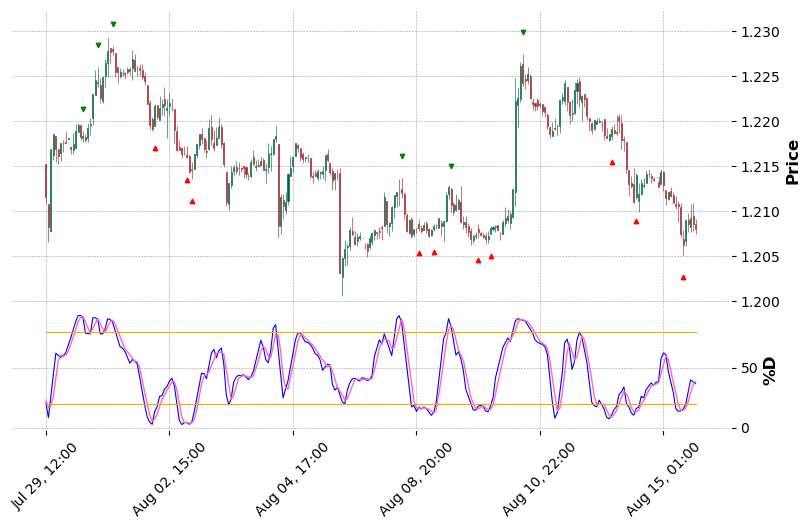

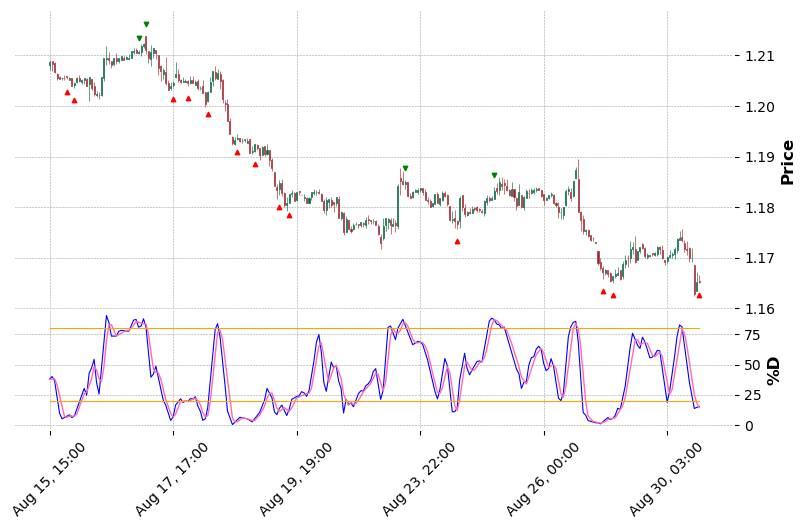

In [133]:
df_windows = np.linspace( 0, len(df), 20 )

for i in range(len(df_windows) - 1):
    start, end = int(df_windows[i]), int(df_windows[i+1])
    stoch_info_plots = stoch_plot(df, start, end)

    mpf.plot(df.iloc[start:end], type='candle', style='charles',
         addplot=stoch_info_plots,
         figsize=(10, 6))

In [153]:
def find_peak(price, i, order):
    
    max_idx = list(argrelextrema(price.values[:i], np.greater, order=order)[0])
    min_idx = list(argrelextrema(price.values[:i], np.less, order=order)[0])

    idx = max_idx + min_idx + [len(price.values[:i]) - 1]
    idx.sort()
    current_idx = idx[-6:]
    
    start = min(current_idx)
    end = max(current_idx)
    
    current_pat = price.values[current_idx]
    
    return current_pat, current_idx, start, end

In [154]:
def find_trend(current_pat):
    
    if current_pat[0] < current_pat[1] and current_pat[0] < current_pat[2] and current_pat[0] < current_pat[4] and \
        current_pat[1] > current_pat[2] and current_pat[1] < current_pat[3] and current_pat[2] < current_pat[3] and \
        current_pat[2] < current_pat[4] and current_pat[3] > current_pat[4]:
        
        return 'up'

    elif current_pat[0] > current_pat[1] and current_pat[0] > current_pat[2] and current_pat[0] > current_pat[4] and \
        current_pat[1] < current_pat[2] and current_pat[1] > current_pat[3] and current_pat[2] > current_pat[3] and \
        current_pat[2] > current_pat[4] and current_pat[3] < current_pat[4]:
        
        return 'down'

    elif current_pat[0] < current_pat[1] and current_pat[0] < current_pat[2] and current_pat[0] < current_pat[4] and \
        current_pat[1] > current_pat[2] and current_pat[1] < current_pat[3] and current_pat[2] < current_pat[3] and \
        current_pat[2] > current_pat[4] and current_pat[3] > current_pat[4]:
        
        return 'up end'

    elif current_pat[0] > current_pat[1] and current_pat[0] > current_pat[2] and current_pat[0] > current_pat[4] and \
        current_pat[1] < current_pat[2] and current_pat[1] > current_pat[3] and current_pat[2] > current_pat[3] and \
        current_pat[2] < current_pat[4] and current_pat[3] < current_pat[4]:
        
        return 'down end'

    else:
        return False

down


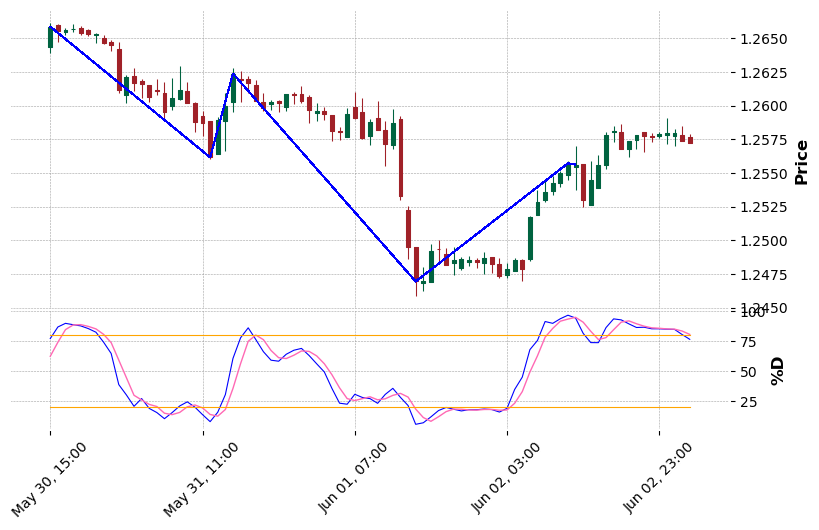

down


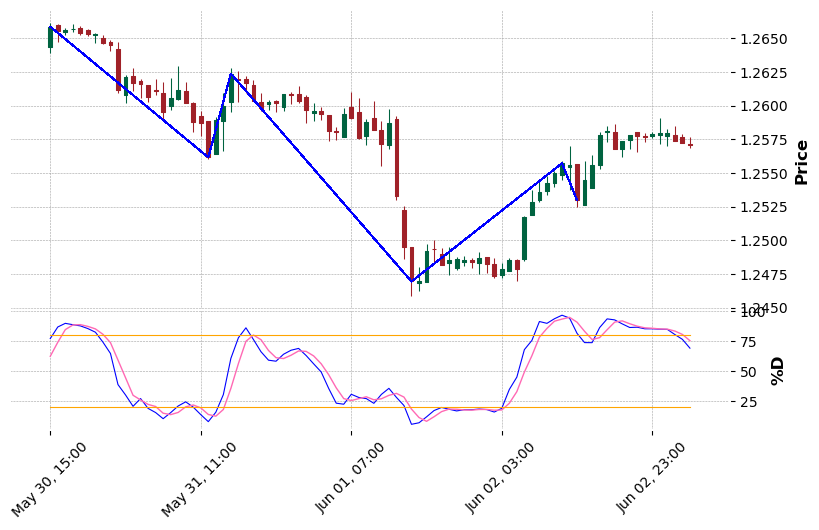

down


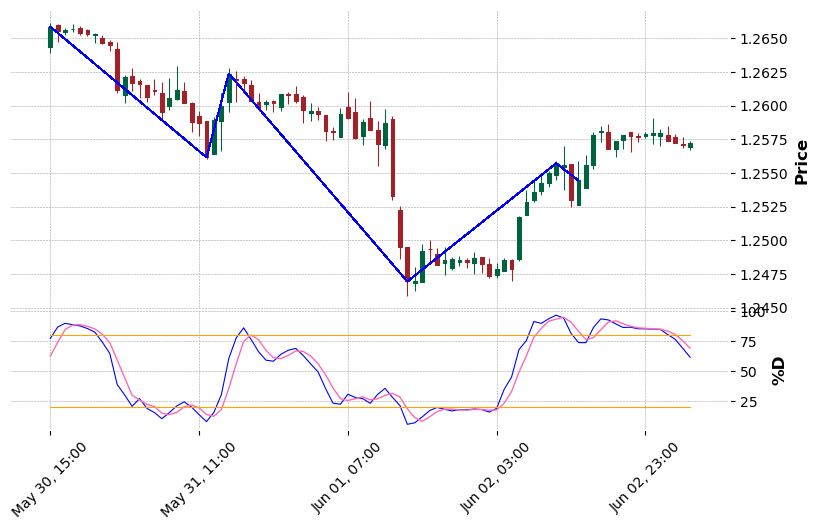

down


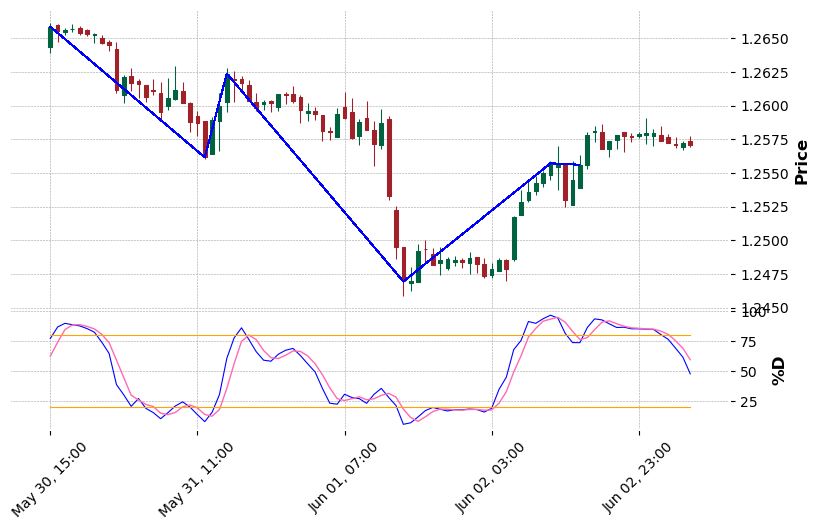

down


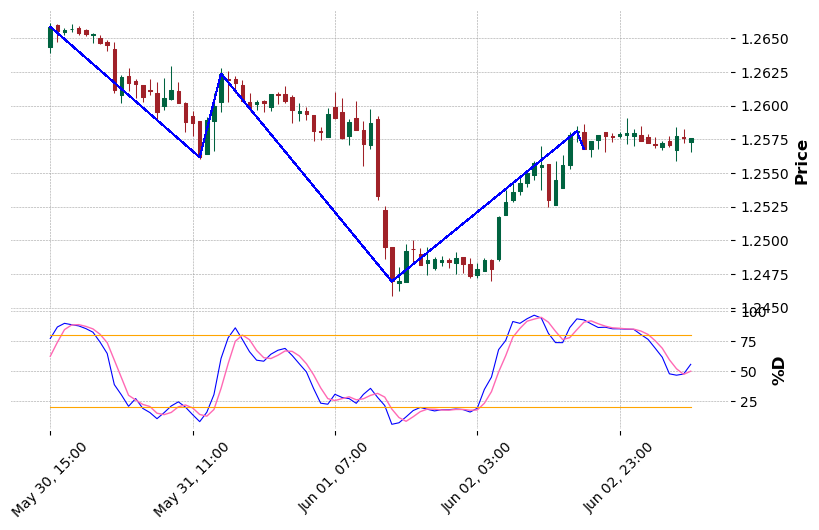

down


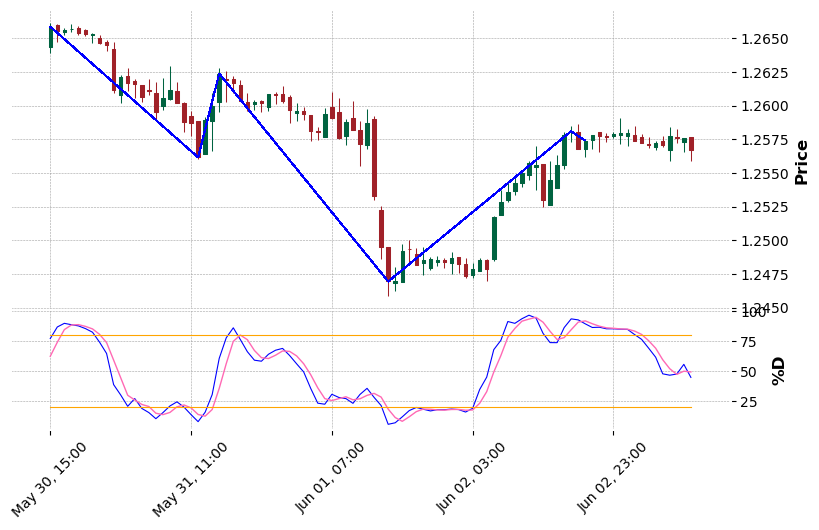

down


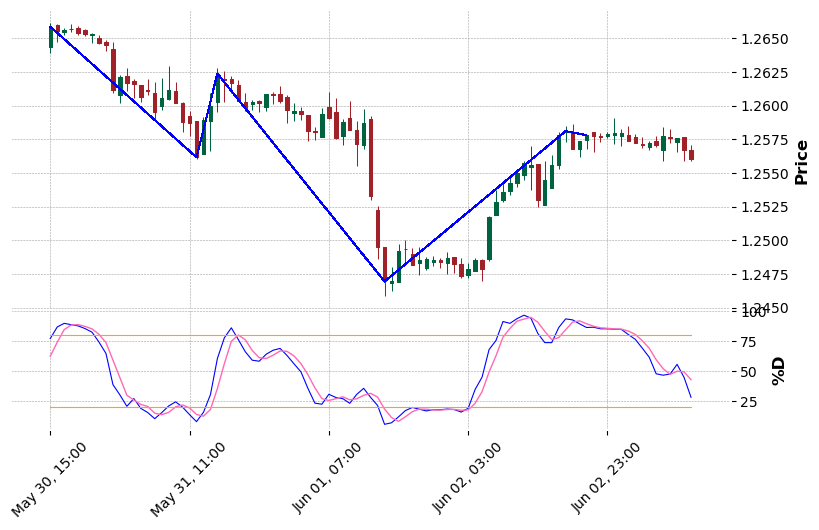

down


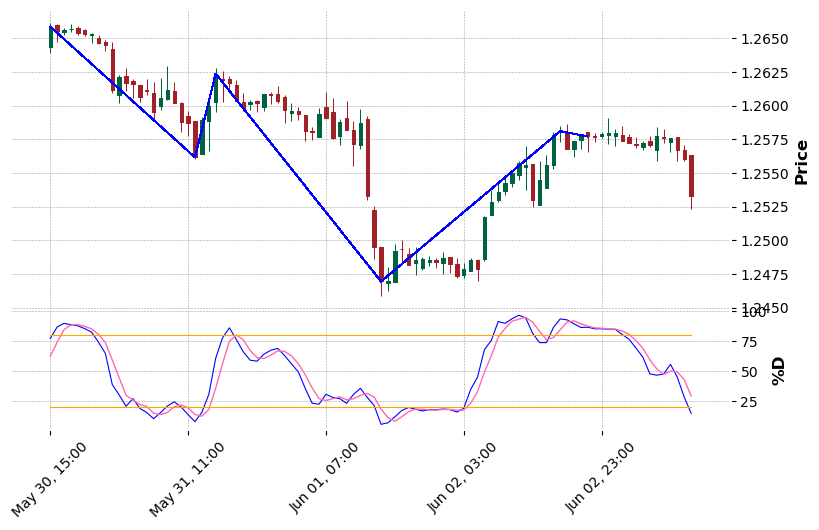

down


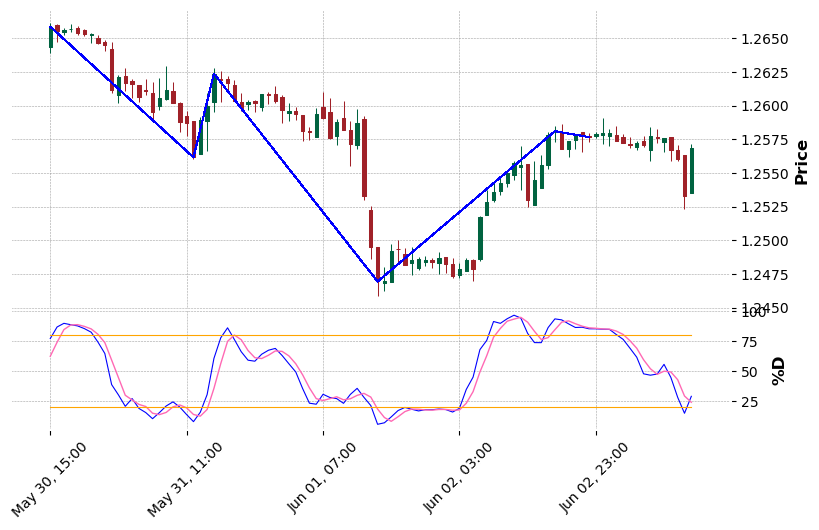

down


down


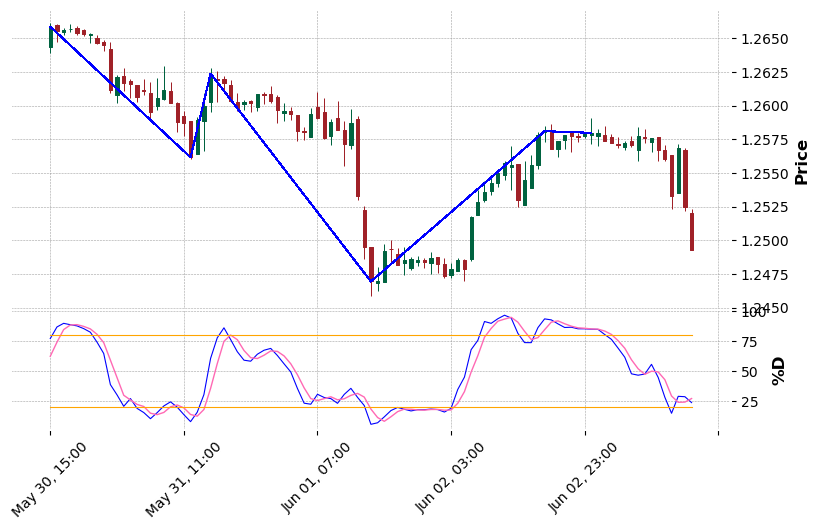

down


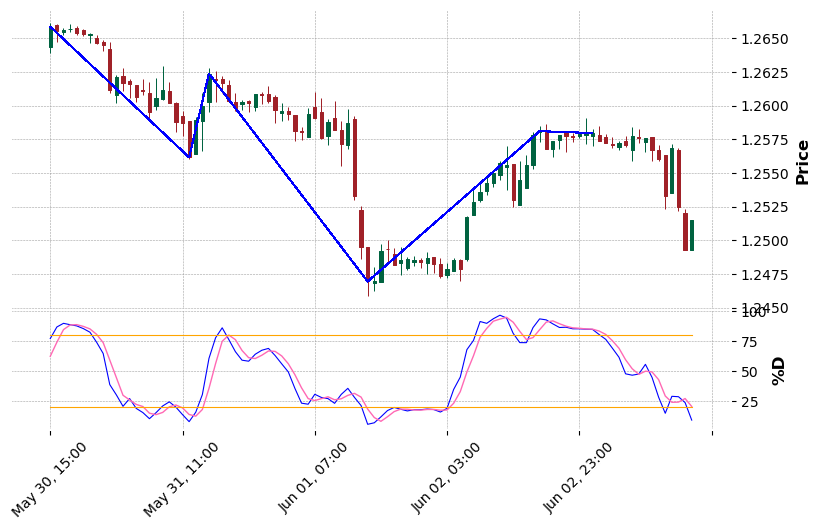

down


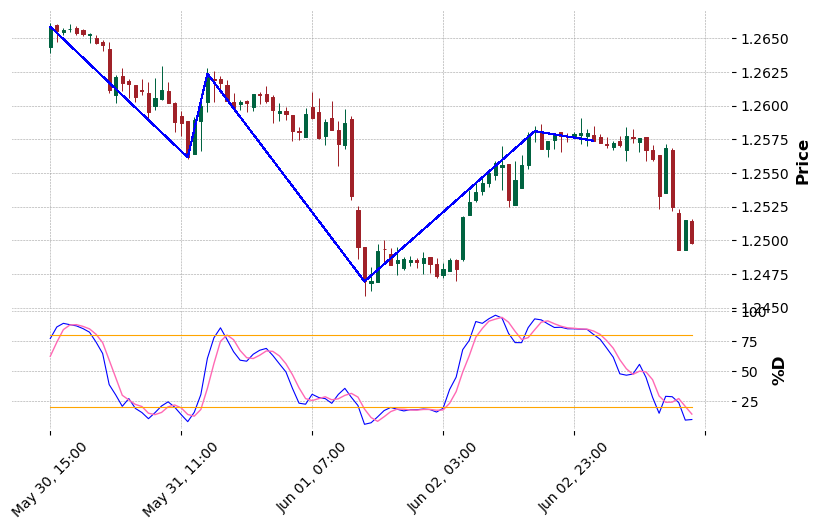

down


down


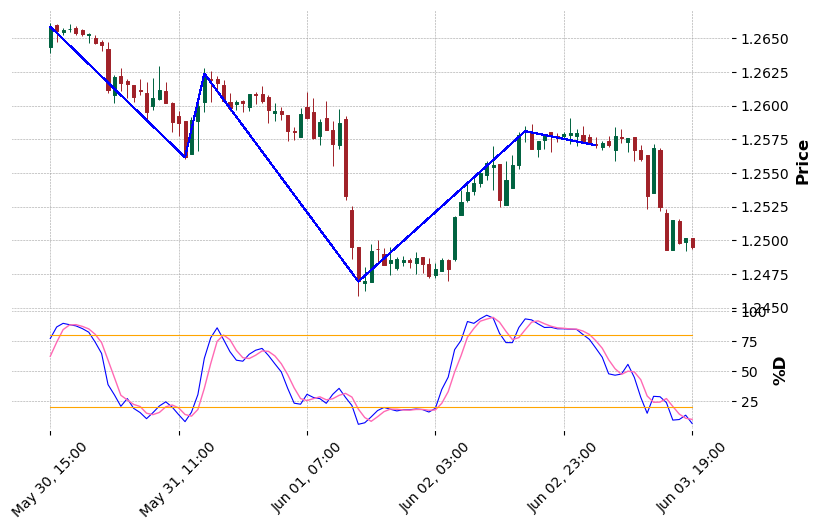

down


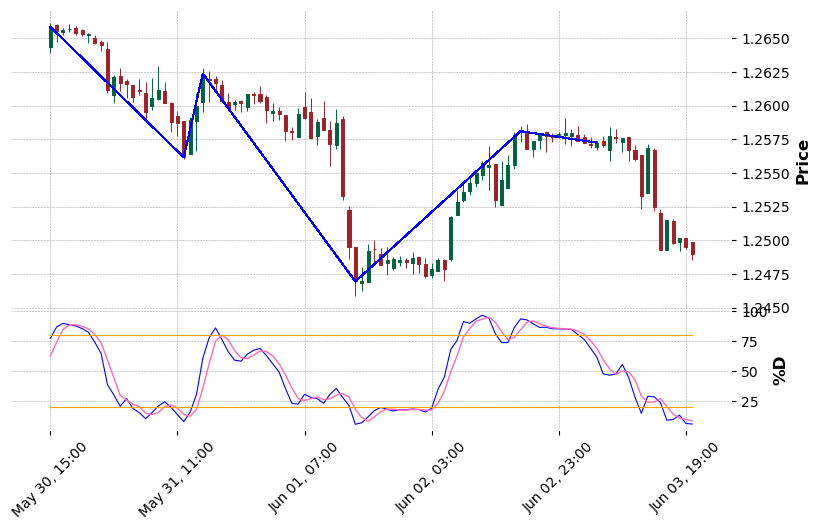

down


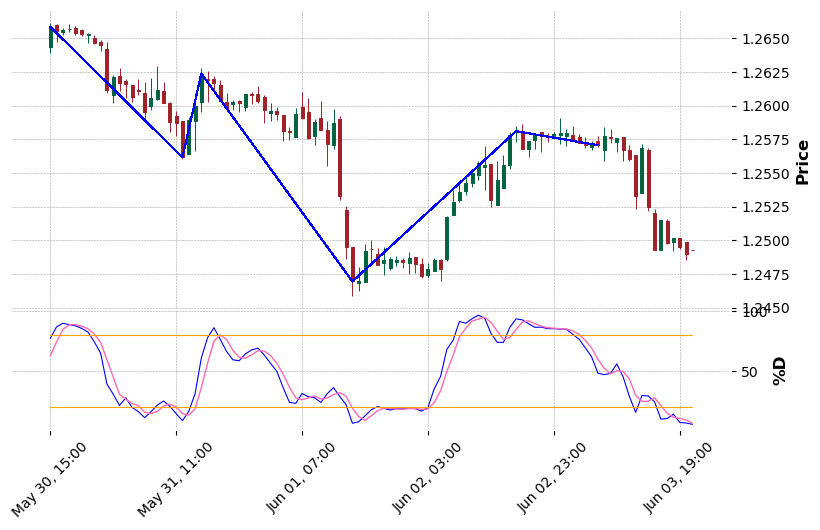

down


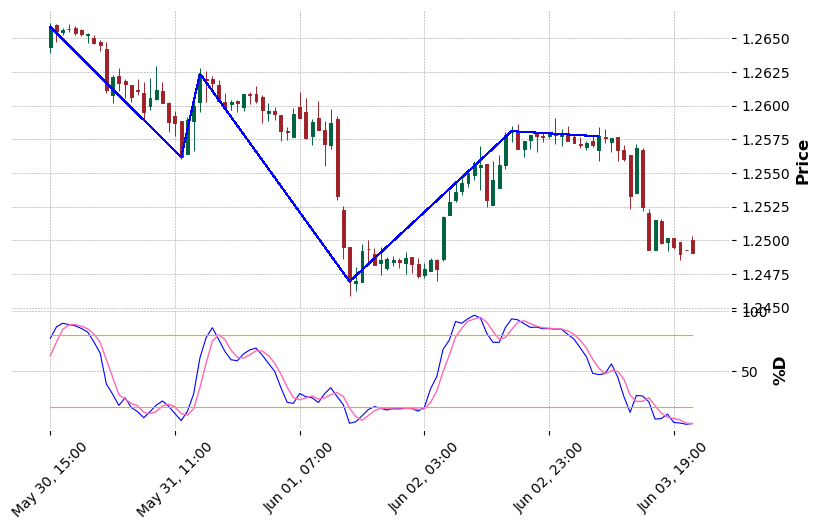

down


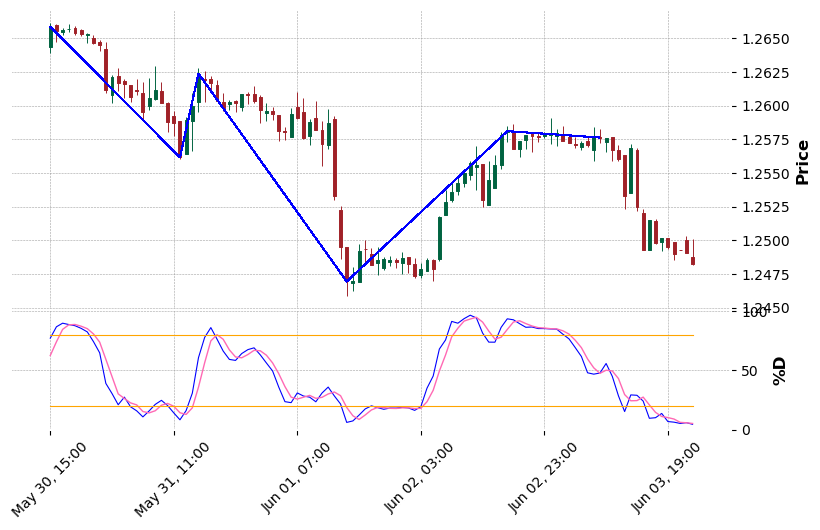

down


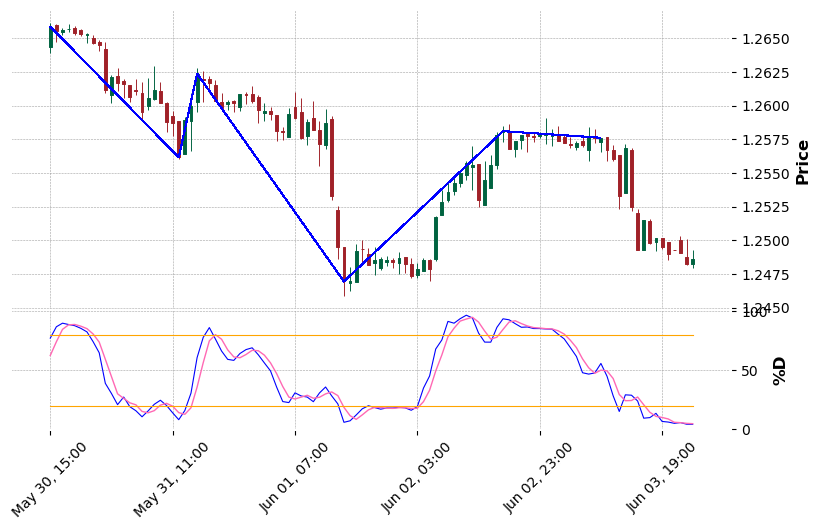

down


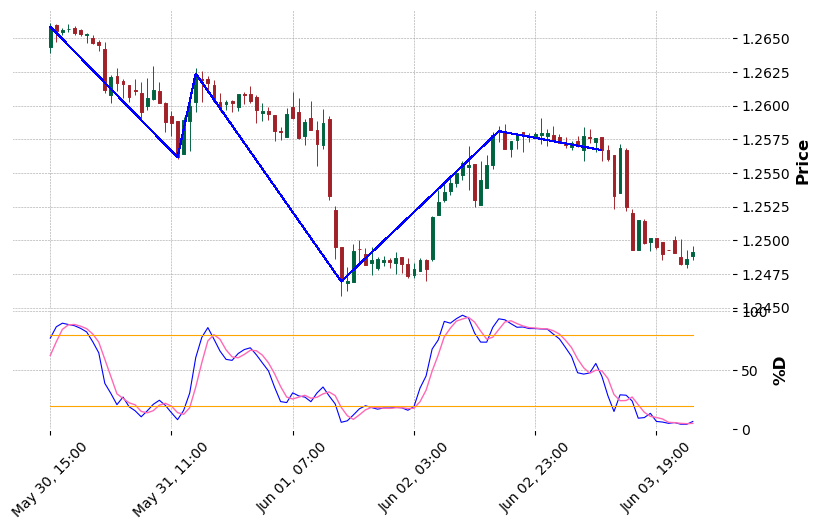

down


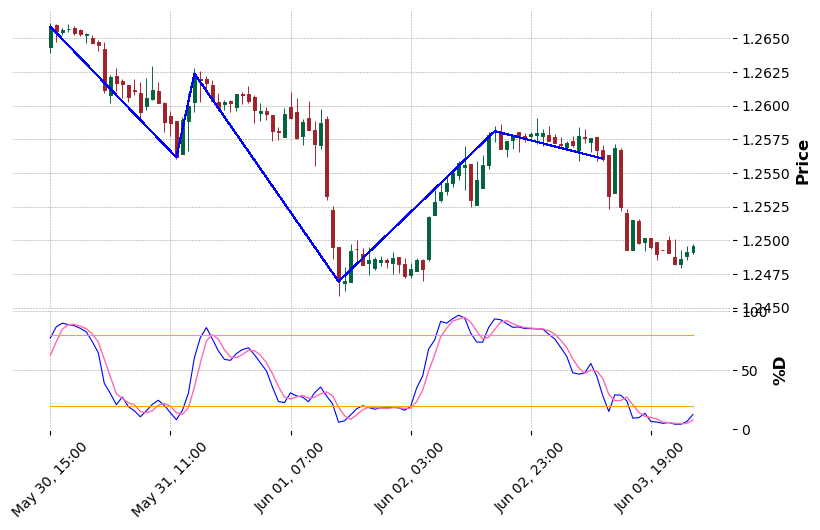

down


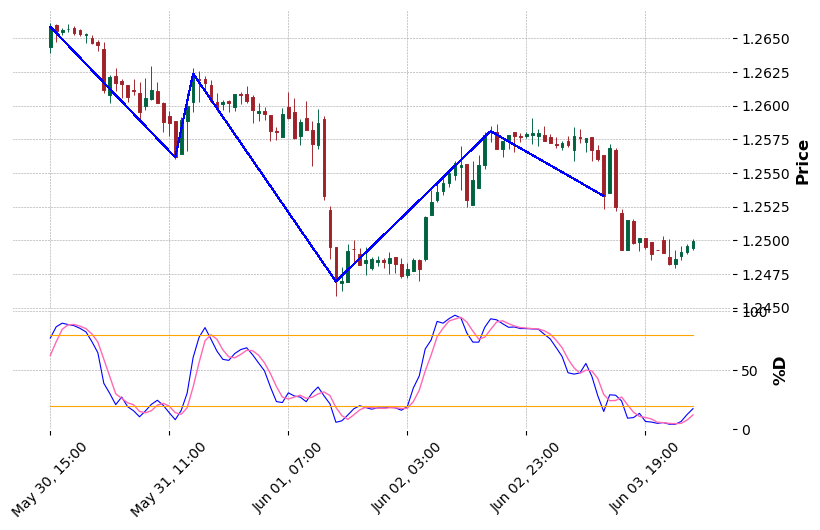

down


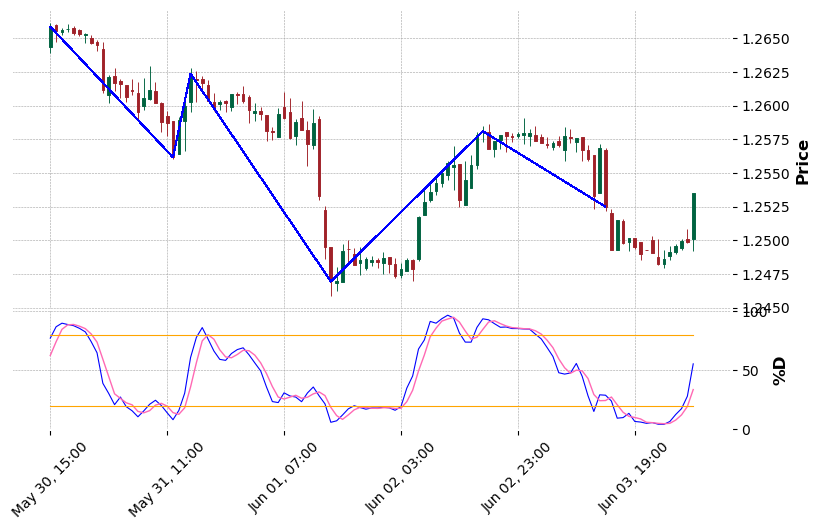

down


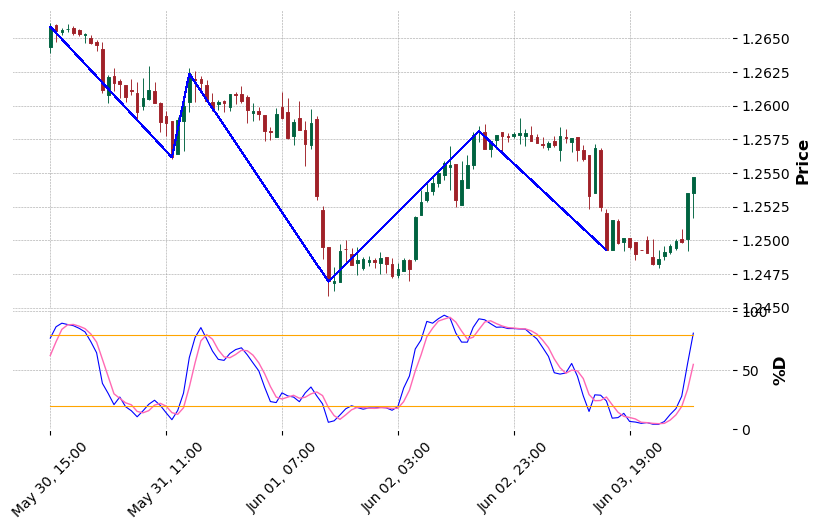

down


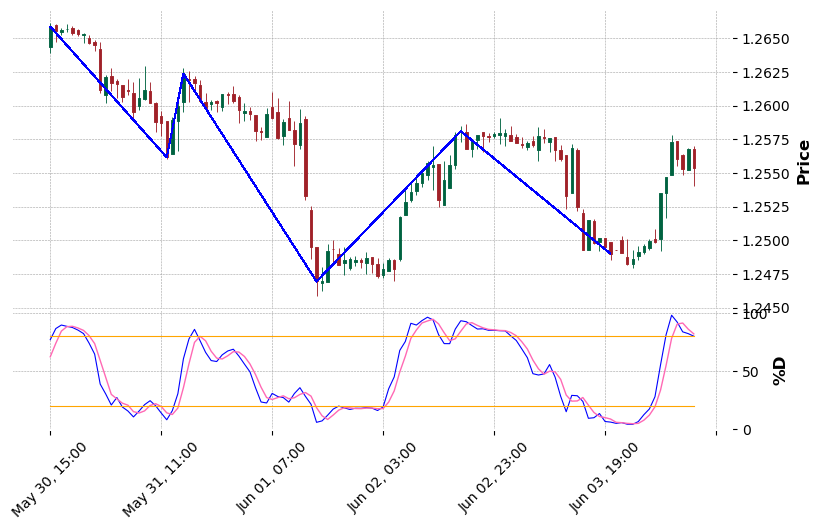

down


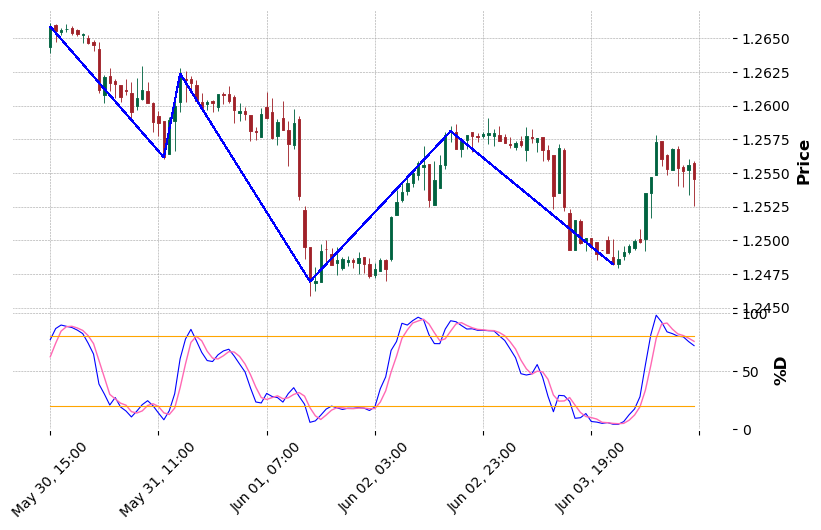

down


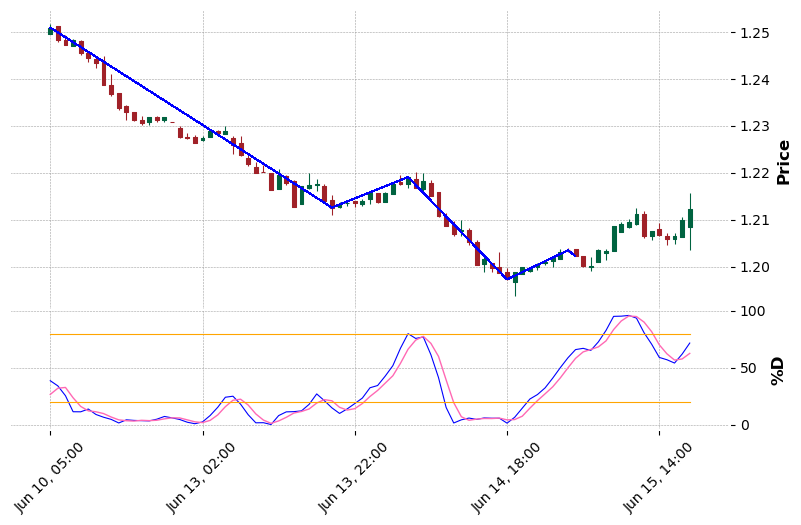

down


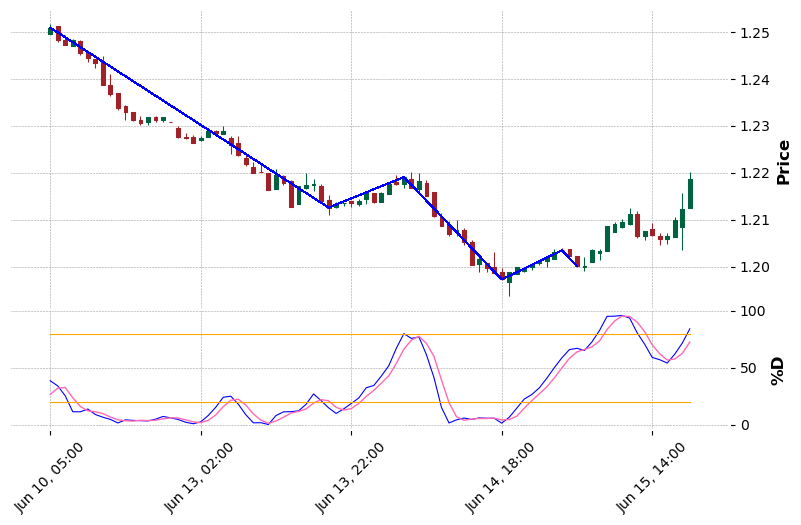

down


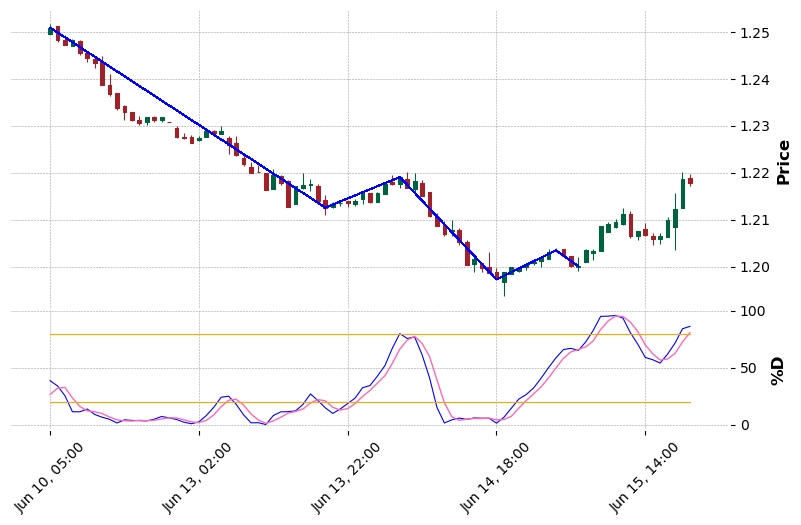

down


down


down


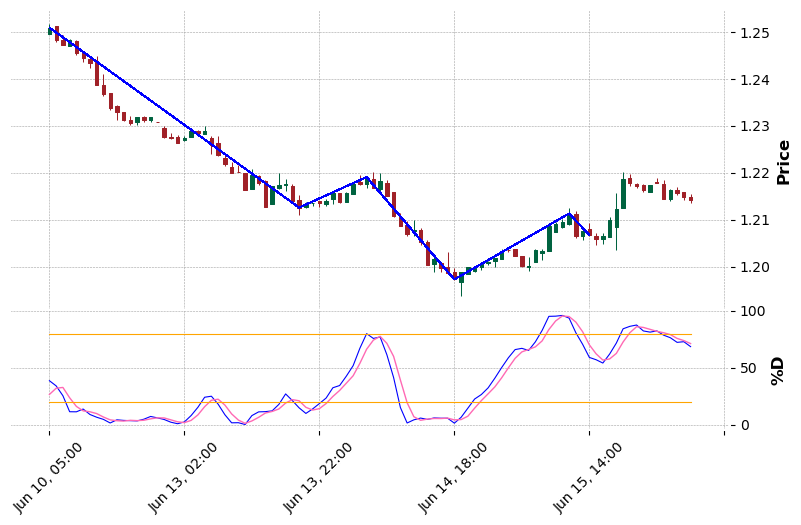

down


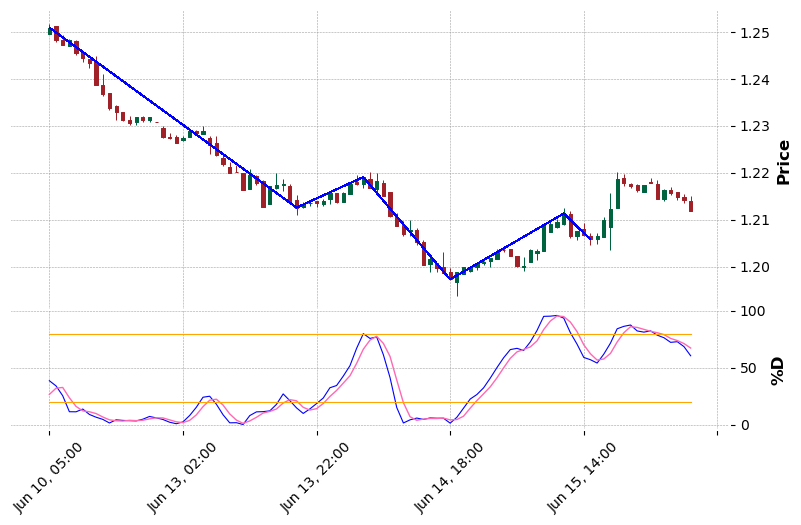

down


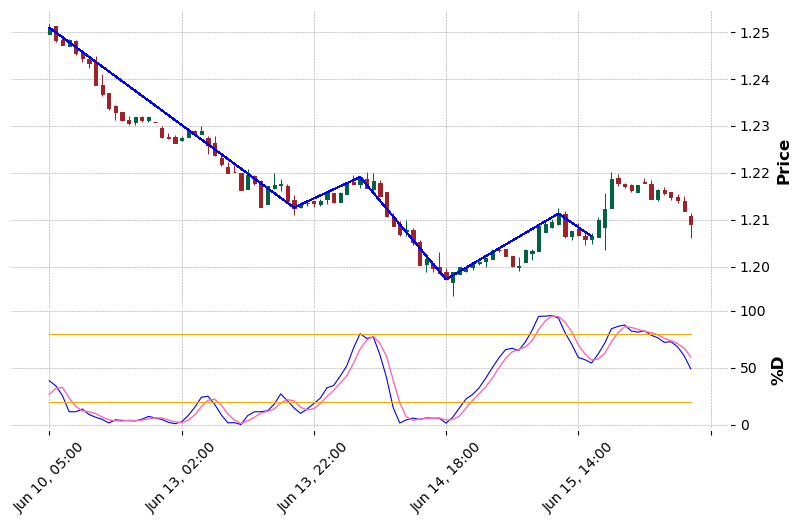

down


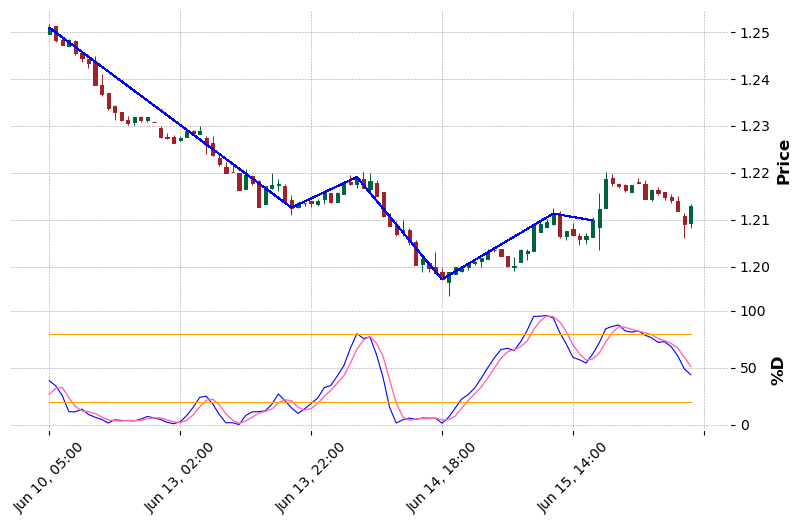

down


down


down


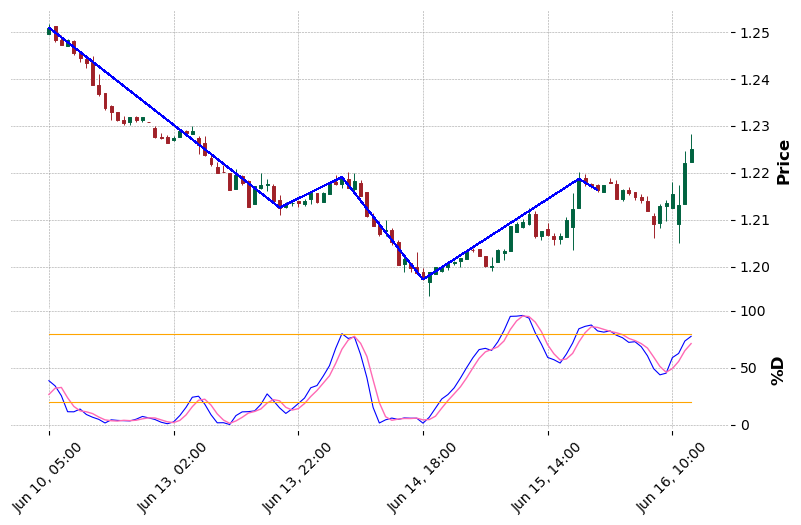

down


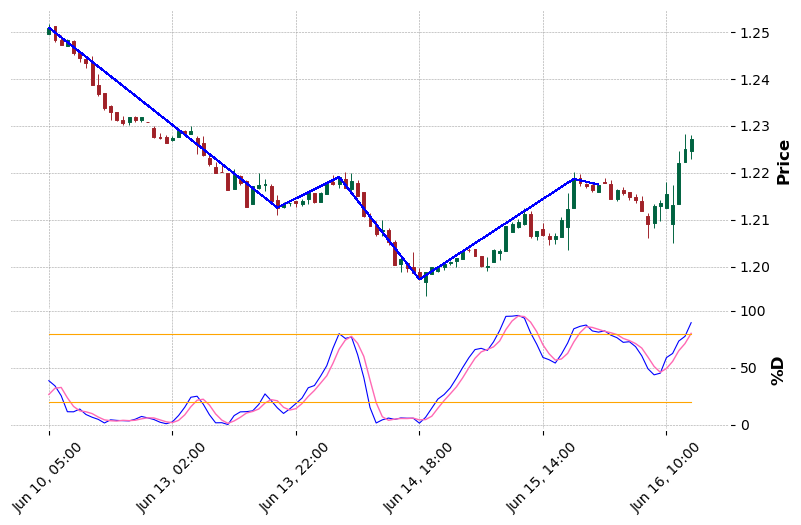

down


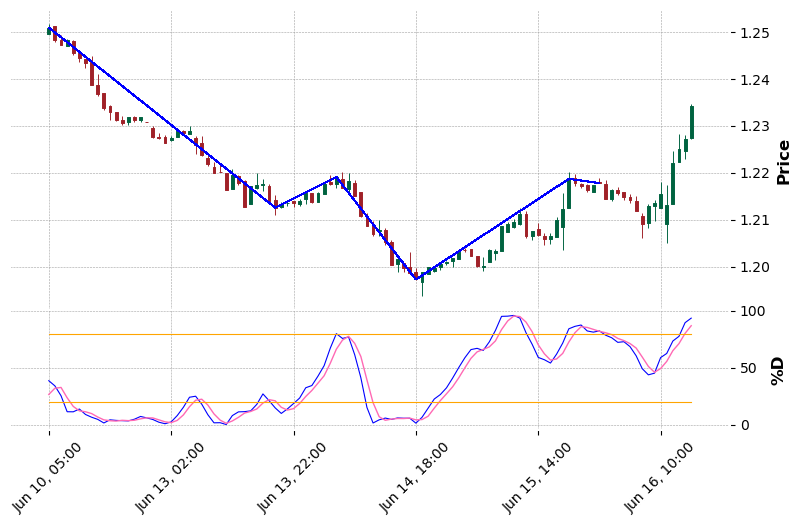

down


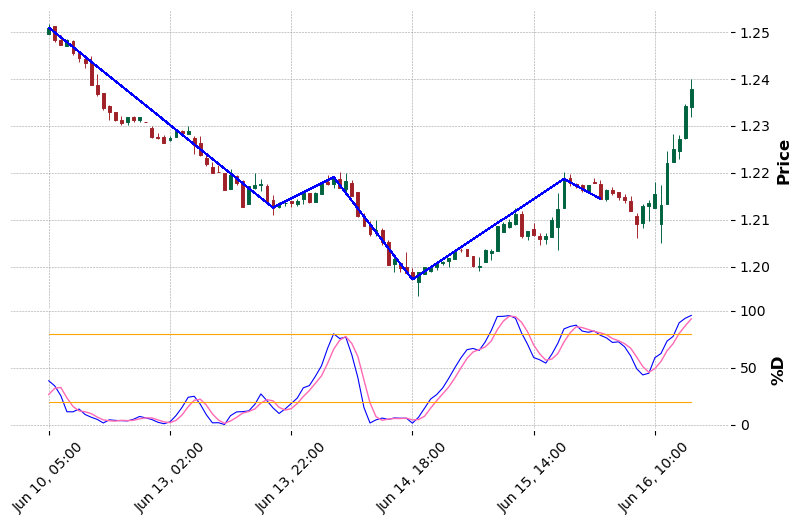

down


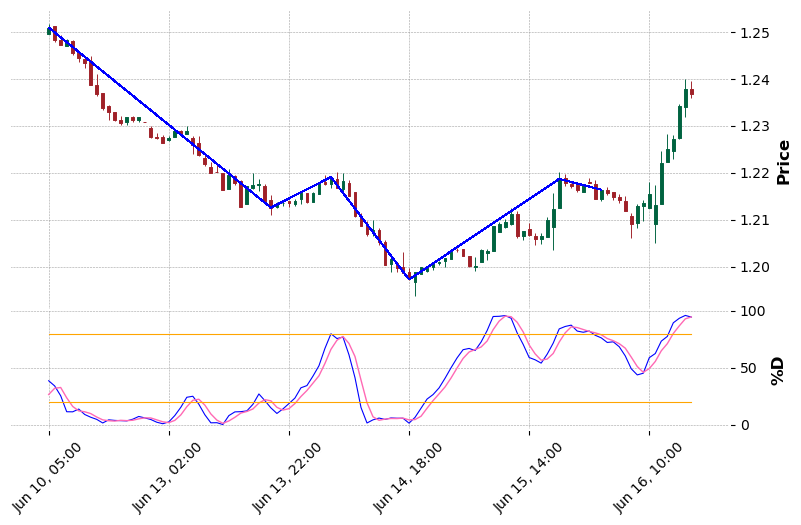

down


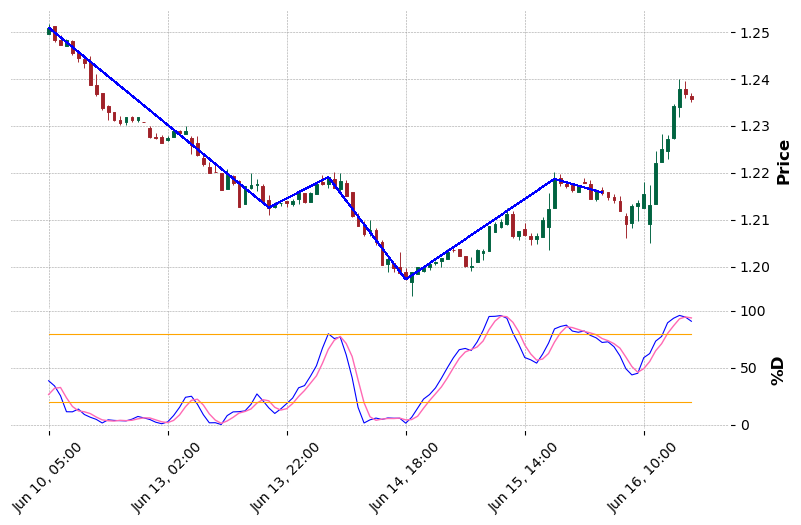

down


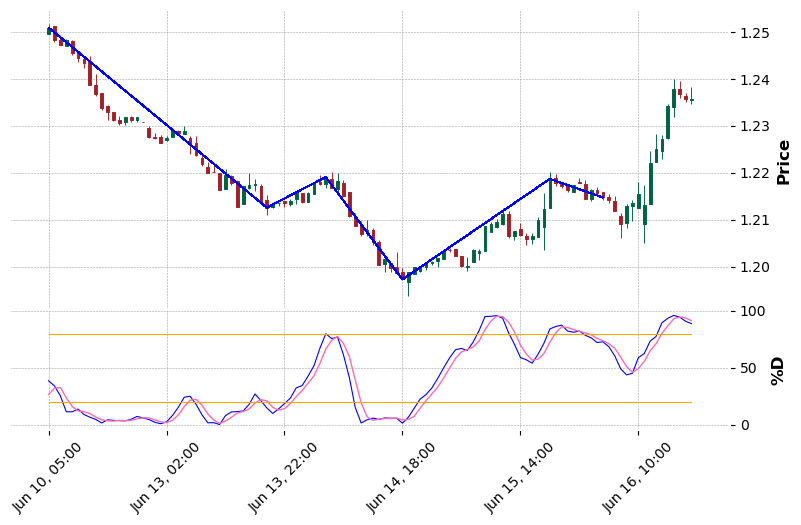

down


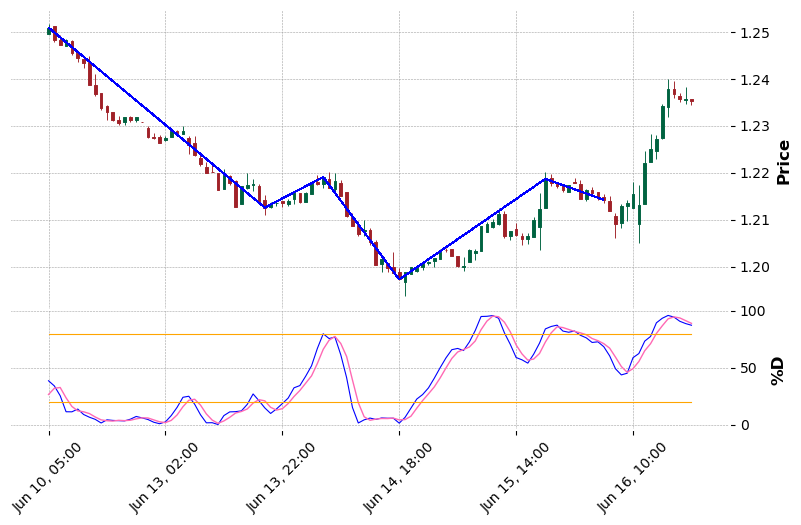

down


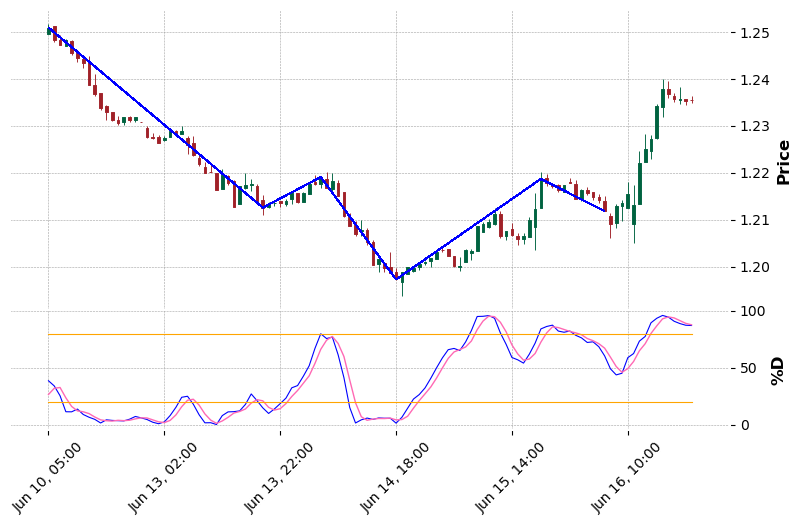

down


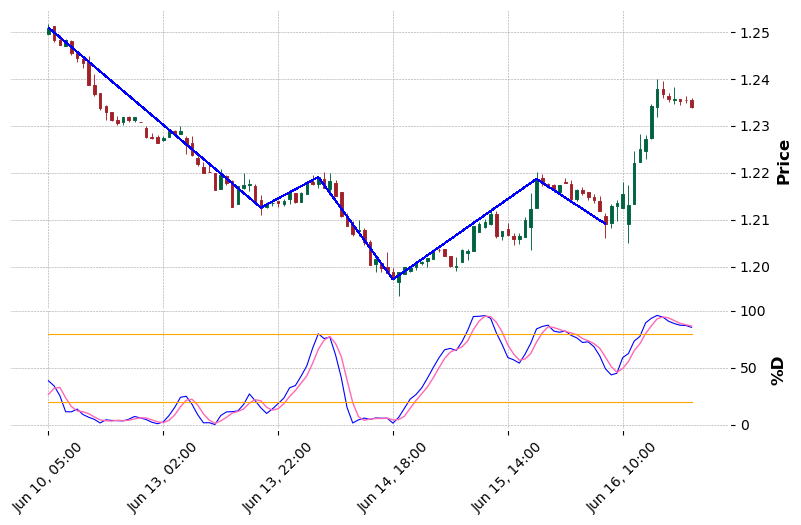

down


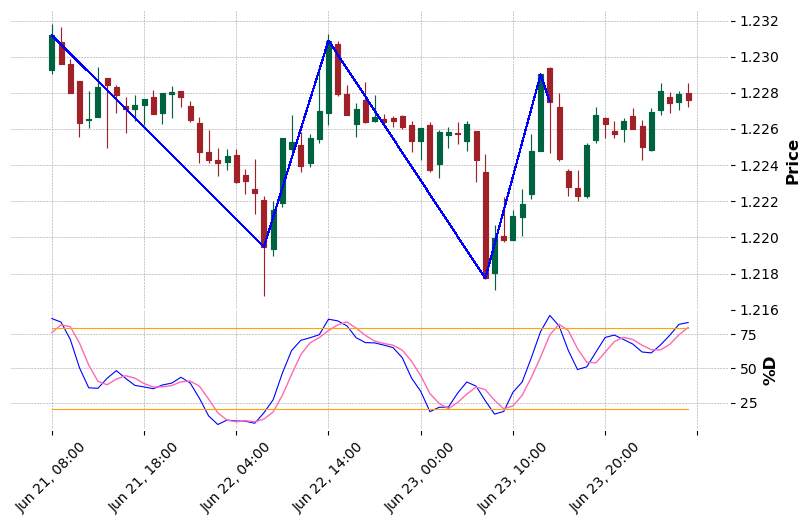

down


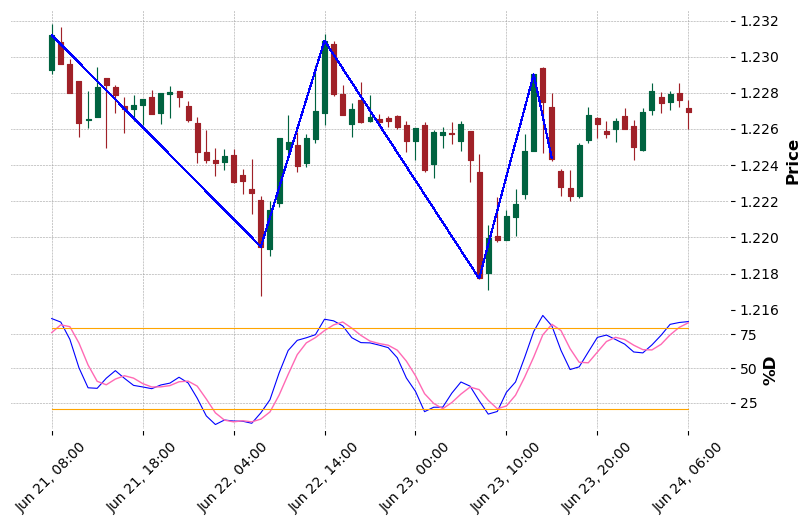

down


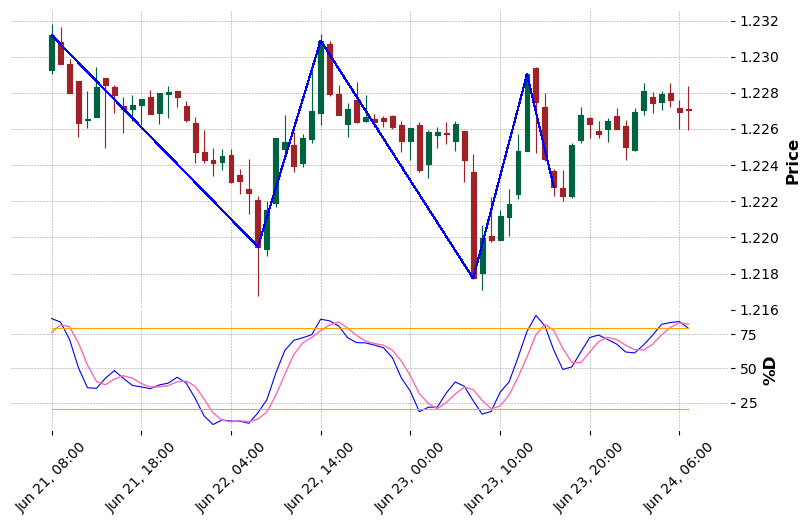

down


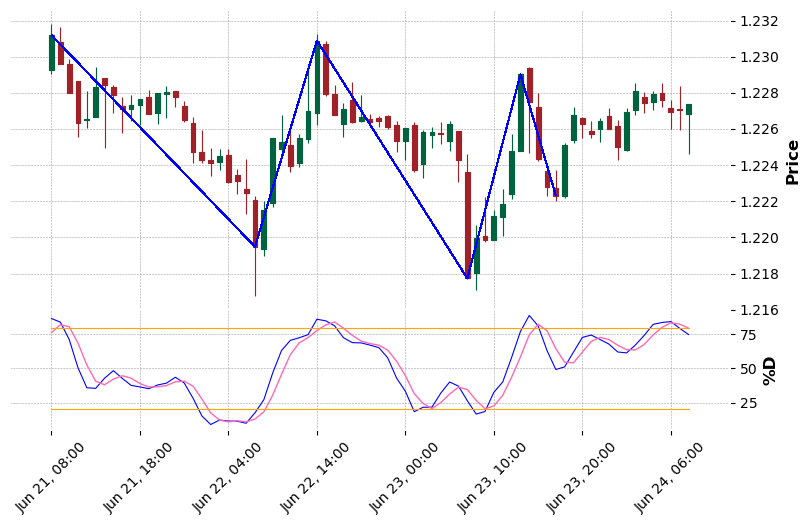

down


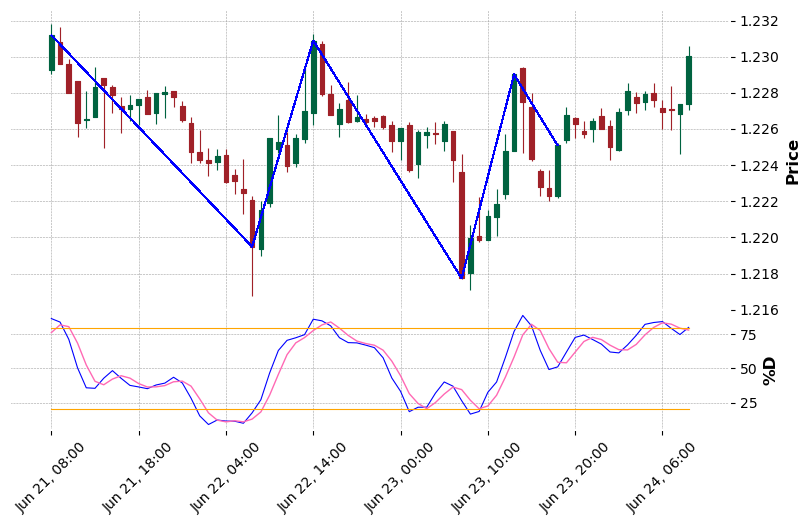

down


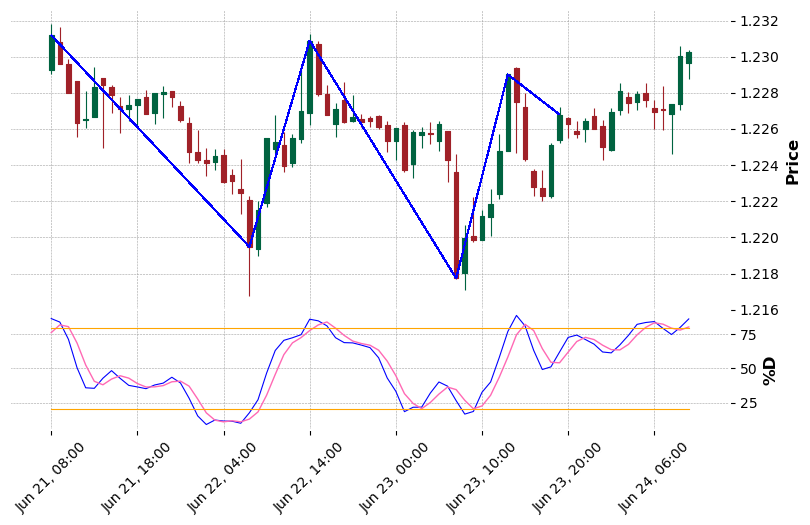

down


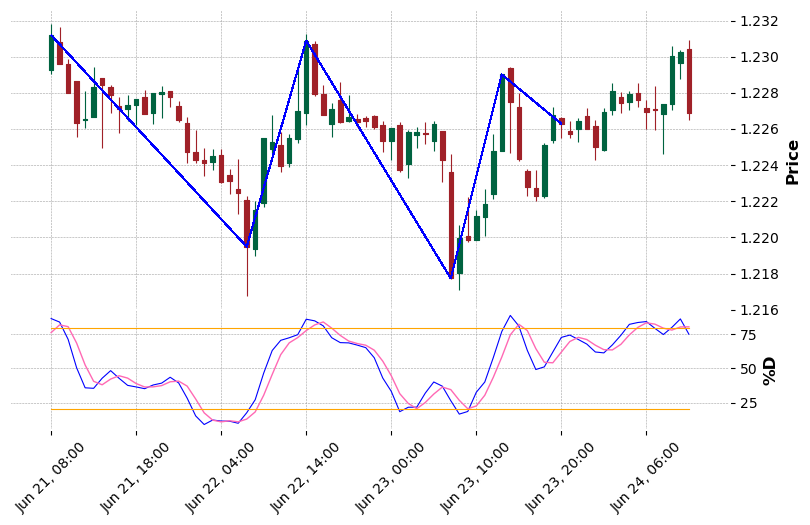

down


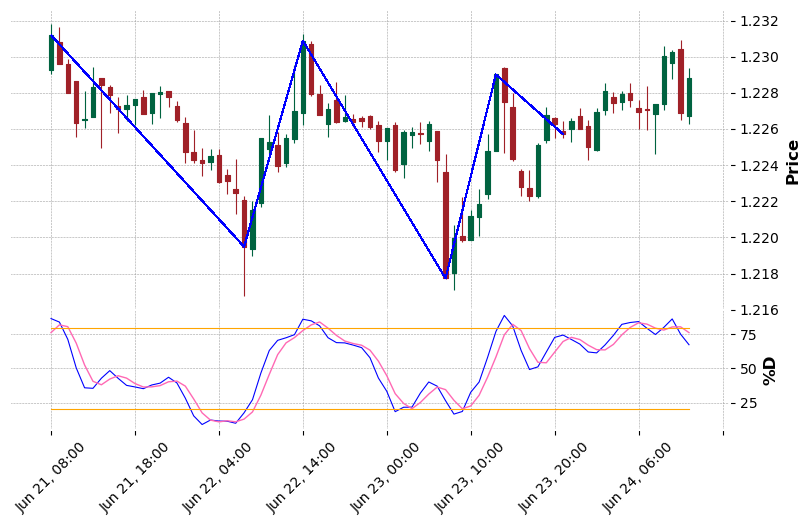

down


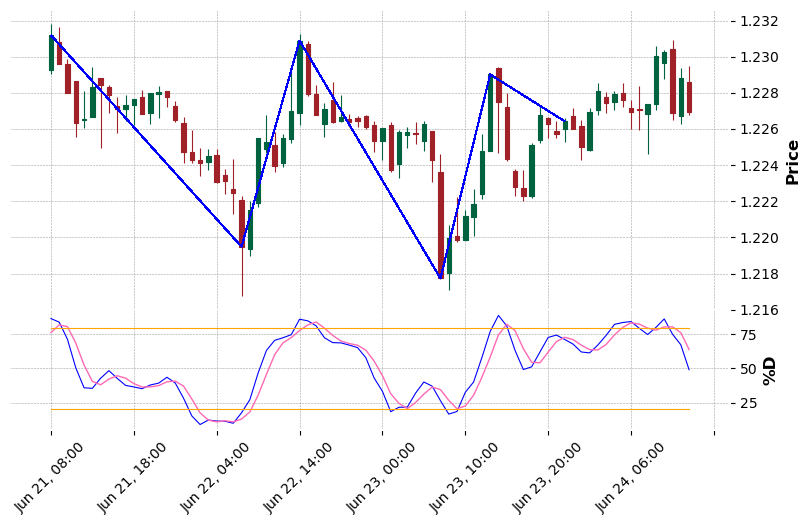

down


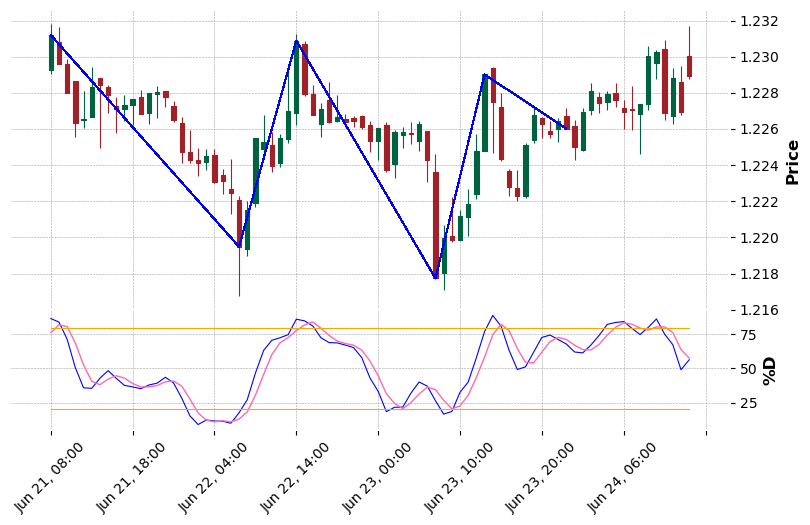

down


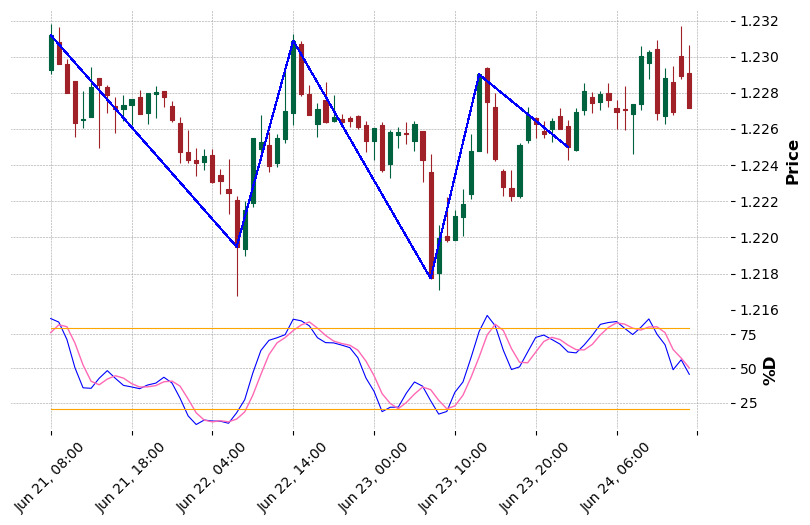

down


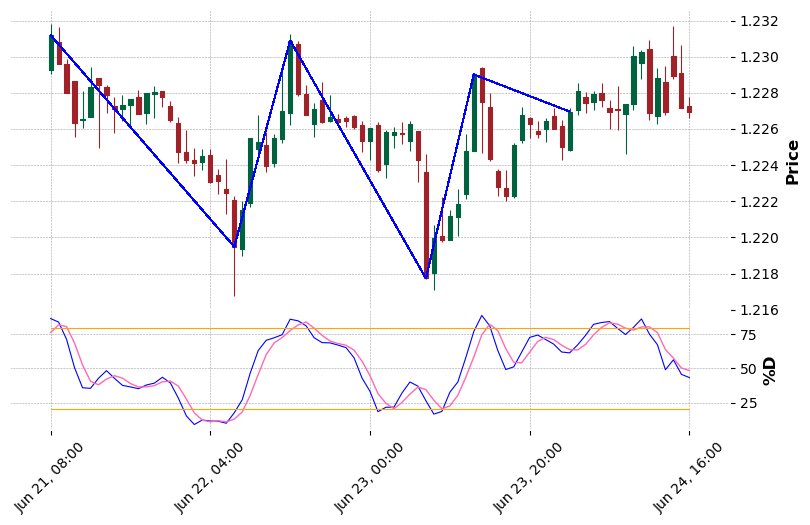

down


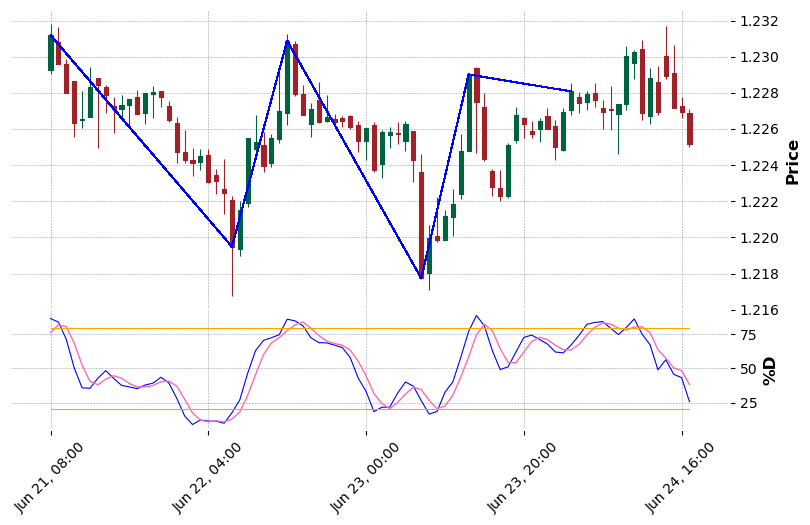

down


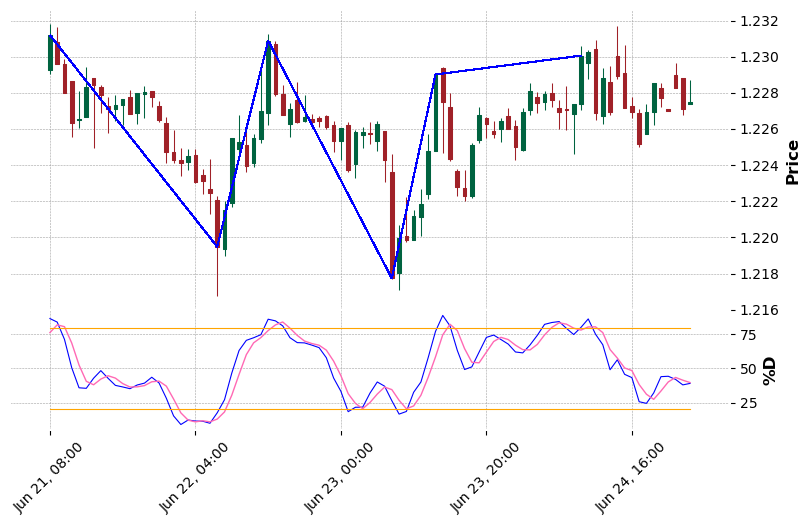

down


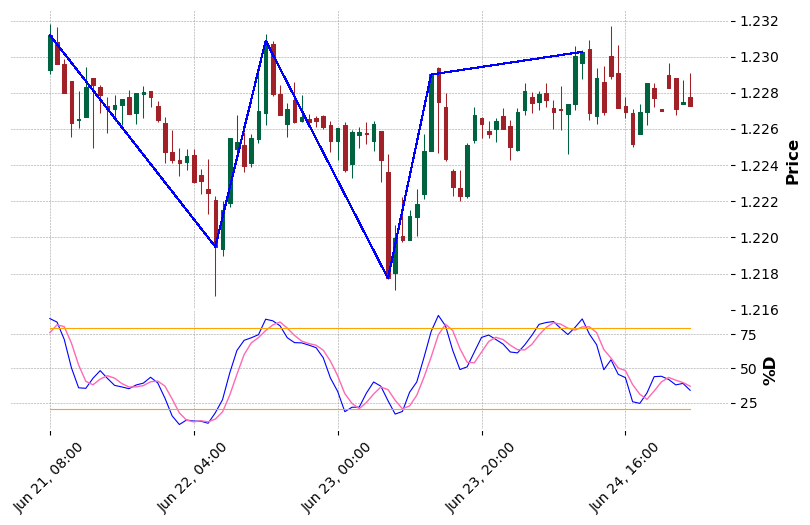

down


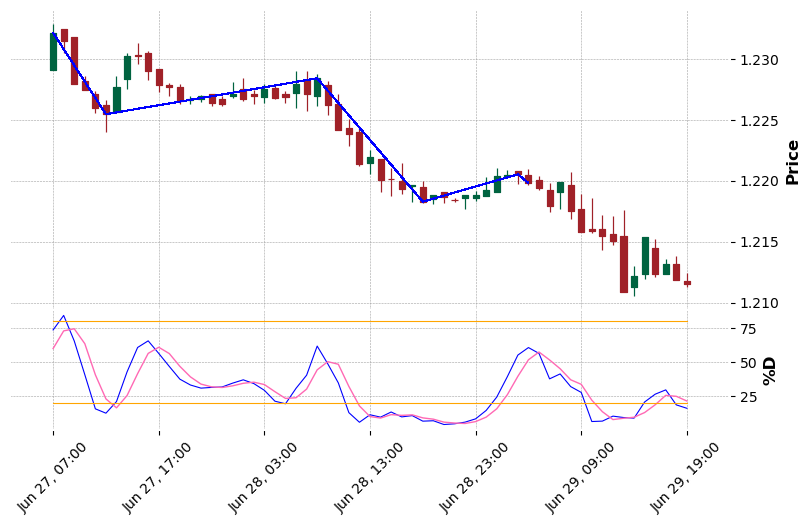

down


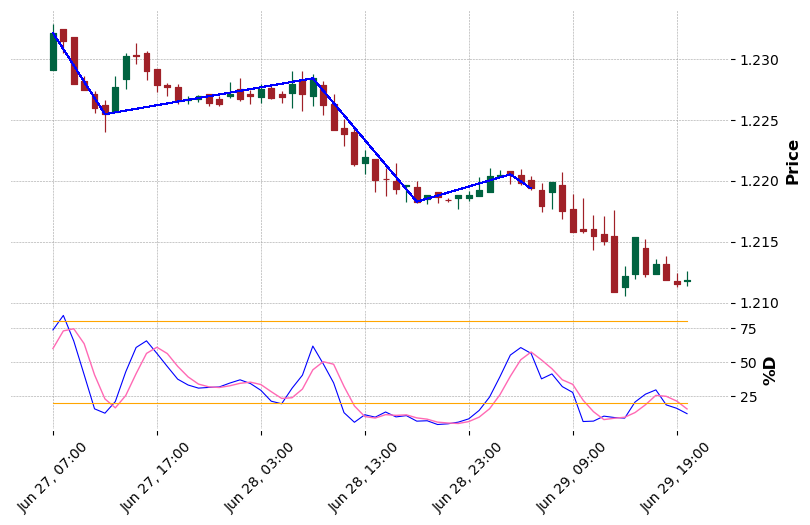

down


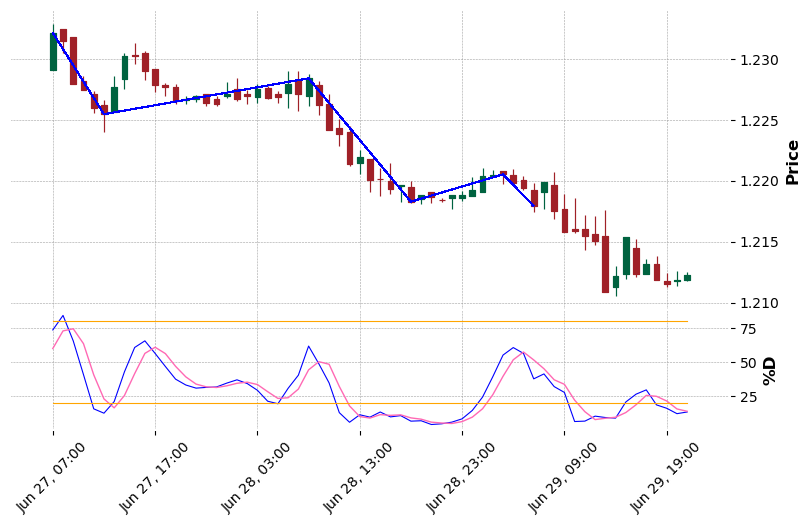

down


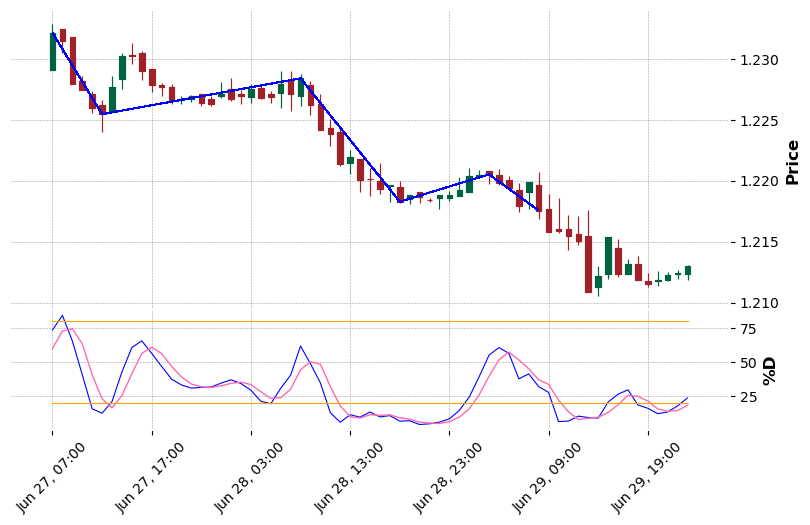

down


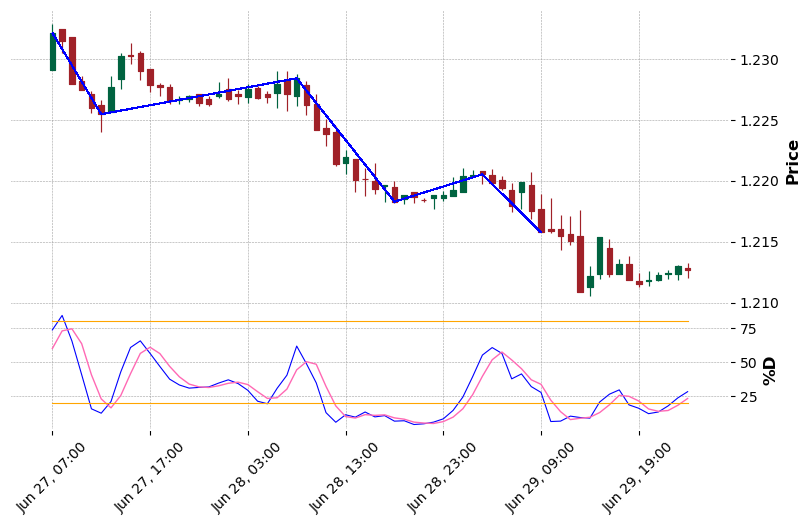

down


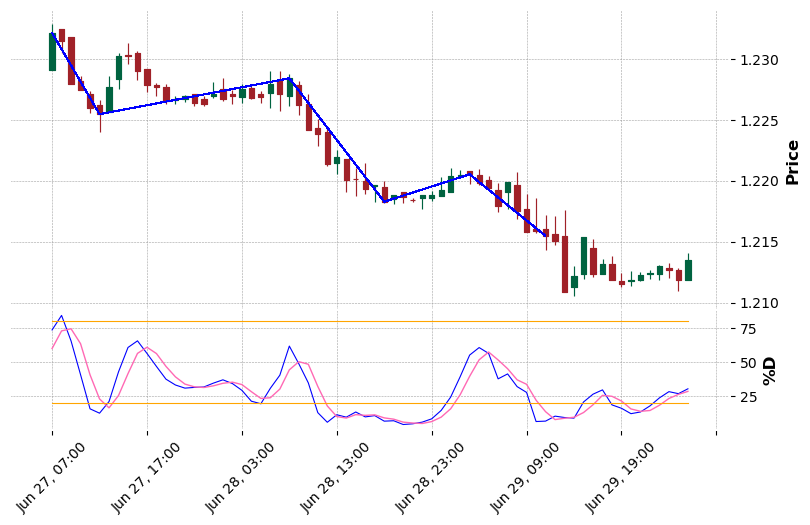

down


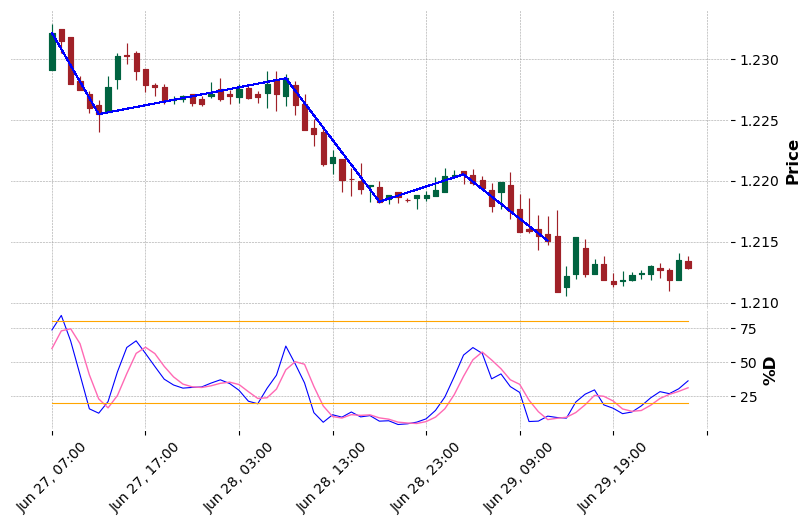

down


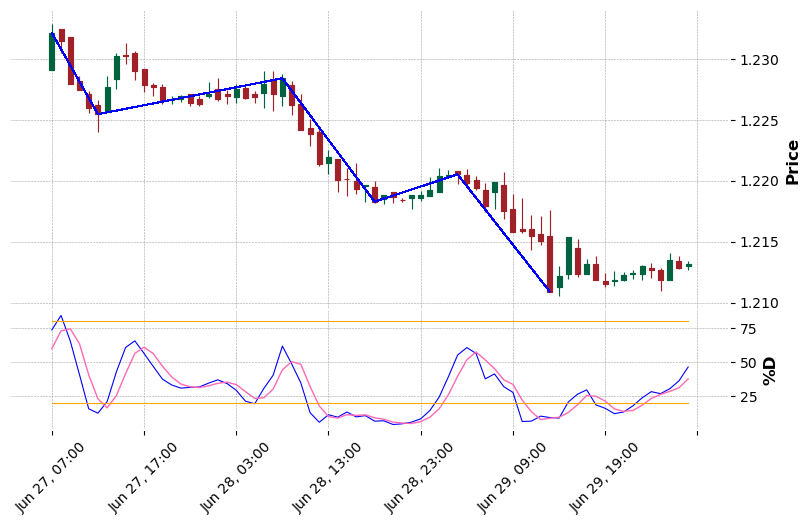

In [177]:
price = df['close'].copy()
for i in range(3500, 4000):
    
     current_pat, current_idx, start, end = find_peak(price, i, 10)
     peak_lines = [(price.index[current_idx[i]], current_pat[i]) for i in range(len(current_pat))]
     trend = find_trend(current_pat) # , err_allowed)
     # print(current_pat)
    
     if trend == 'down': #is not False:
          print(trend)
          mpf.plot(df.iloc[start:i+15], type='candle', style='charles',
               addplot=stoch_plot(df, start, i+15, plot_cross=False),
               alines=dict(alines=peak_lines,colors=['blue'], linewidths=0.8),
               figsize=(10, 6))

In [90]:
# heatmap stoch K 10-20 and overbought/oversold 15-25 and 75-85
class Stoch_Experiment:
    def __init__(self, params):
        
        self.current_action = 'close'
        self.stoch = params['stoch']
        
        self.ema = params['ema']
        self.rr = params['rr']
        self.overbought = params['overbought']
        self.oversold = params['oversold']
        
        self.df = params['df']
        self.indicator_name = '_STOCH'+str(self.stoch)+'_OVERB'+str(self.overbought)+'_OVERS'+str(self.oversold)
        
        self.latest_sl = 0
        self.latest_tp = 0
        self.latest_entry = 0
        self.status = 'idle' # idle, overbought, oversold
        
    def get_df(self):
        return self.df
    
    def calLotSize(self, entry, exit):
        return abs(round(self.target_tp / (entry - exit)  , 2))
#         return abs(round(self.target_tp / (((entry - exit) / self.pip ) * self.pip_value ) , 2))

    def longCondition(self, row):
        if row['prev_d'+self.indicator_name] < row['prev_k'+self.indicator_name] and \
                row['STOCHd_'+str(self.stoch)+'_3_3'] > row['STOCHk_'+str(self.stoch)+'_3_3'] and \
                row['prev_k'+self.indicator_name] < self.oversold: # and row['EMA_'+str(self.ema)] < row['low']:
            row['entries'+self.indicator_name] = True
            self.status = 'idle'
            self.current_action = 'long'
            self.latest_entry = row['open']
                
    def longResult(self, row):
        if  row['prev_d'+self.indicator_name] > row['prev_k'+self.indicator_name] and \
                row['STOCHd_'+str(self.stoch)+'_3_3'] < row['STOCHk_'+str(self.stoch)+'_3_3'] and \
                row['prev_k'+self.indicator_name] > self.overbought: # row['EMA_'+str(self.ema)] > row['high']
            self.current_action = 'close'
            row['exits'+self.indicator_name] = True
            row['price_action'+self.indicator_name] = row['open']

    def shortCondition(self, row):
        if row['prev_d'+self.indicator_name] > row['prev_k'+self.indicator_name] and \
                row['STOCHd_'+str(self.stoch)+'_3_3'] < row['STOCHk_'+str(self.stoch)+'_3_3'] and \
                row['prev_k'+self.indicator_name] > self.overbought:
                    
            row['short_entries'+self.indicator_name] = True
            self.current_action = 'short'
            self.status = 'idle'
            self.latest_entry = row['open']
                
    def shortResult(self, row):
        if row['prev_d'+self.indicator_name] < row['prev_k'+self.indicator_name] and \
                row['STOCHd_'+str(self.stoch)+'_3_3'] > row['STOCHk_'+str(self.stoch)+'_3_3'] and \
                row['prev_k'+self.indicator_name] < self.oversold:
            self.current_action = 'close'
            row['short_exits'+self.indicator_name] = True
            row['price_action'+self.indicator_name] =  row['open']
                                
    def createLongOrders(self, row):
        if self.current_action == 'close':
            self.longCondition(row)
            self.longResult(row)
        else:
            self.longResult(row)
        
        return row

    def createShortOrders(self, row):
        if self.current_action == 'close':
            self.shortCondition(row)
            self.shortResult(row)
        else:
            self.shortResult(row)
                    
        return row
                    
    def createStrategy(self):
        stoch_ema = ta.Strategy(
            name = 'Stochastic and EMA',
            description = 'Stochastic and EMA',
            ta = [
                {'kind': 'stoch', 'k': self.stoch},
                {'kind': 'ema', 'length': self.ema}
            ]
        )
        self.df.ta.strategy(stoch_ema)
        
        # self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df['entries'+self.indicator_name] = False
        self.df['exits'+self.indicator_name] = False
        
        self.df['short_entries'+self.indicator_name] = False
        self.df['short_exits'+self.indicator_name] = False
        self.df['price_action'+self.indicator_name] = self.df['open']
        
        self.df['prev_d'+self.indicator_name] = self.df['STOCHd_'+str(self.stoch)+'_3_3'].shift(1)
        self.df['prev_k'+self.indicator_name] = self.df['STOCHk_'+str(self.stoch)+'_3_3'].shift(1)
        
    def getLongOrders(self):
        self.createStrategy()
        self.df = self.df.apply(lambda row : self.createLongOrders(row), axis=1)
                                                                
        return self.df

    def getShortOrders(self):
        self.createStrategy()
        self.df = self.df.apply(lambda row : self.createShortOrders(row), axis=1)
                                                                
        return self.df
    
        

In [140]:
pair_test = Stoch_Experiment({
    'ema': 200,
    'stoch': 20,
    'overbought': 85,
    'oversold': 15,
    'pip': 0.0001,
    'pip_value': 10,
    'rr': 1.5,
    'target_tp': 10,
    'df': df.copy()
})

# result_test = pair_test.getLongOrders()
result_test = pair_test.getShortOrders() #.set_index('timestamp')
result_test

open      high       low     close  adj close  \
timestamp                                                                
2021-11-04 17:00:00  1.349364  1.349437  1.348418  1.349273   1.349273   
2021-11-04 18:00:00  1.349382  1.350366  1.349091  1.349655   1.349655   
2021-11-04 19:00:00  1.349509  1.350475  1.349509  1.350238   1.350238   
2021-11-04 20:00:00  1.350311  1.350457  1.349509  1.350020   1.350020   
2021-11-04 21:00:00  1.349692  1.350202  1.348745  1.350074   1.350074   
...                       ...       ...       ...       ...        ...   
2022-08-30 12:00:00  1.171921  1.172044  1.169098  1.170029   1.170029   
2022-08-30 13:00:00  1.169892  1.171921  1.169180  1.169905   1.169905   
2022-08-30 14:00:00  1.168484  1.168484  1.162372  1.162926   1.162926   
2022-08-30 15:00:00  1.163399  1.167174  1.163399  1.165189   1.165189   
2022-08-30 16:00:00  1.165365  1.166521  1.164985  1.165189   1.165189   

                     volumn  STOCHk_20_3_3  STOCHd_20_3_3   EMA_200  \
timestamp                                                             
2021-11-04 17:00:00       0            NaN            NaN       NaN   
2021-11-04 18:00:00       0            NaN            NaN       NaN   
2021-11-04 19:00:00       0            NaN            NaN       NaN   
2021-11-04 20:00:00       0            NaN            NaN       NaN   
2021-11-04 21:00:00       0            NaN            NaN       NaN   
...                     ...            ...            ...       ...   
2022-08-30 12:00:00       0      35.351567      50.205728  1.182105   
2022-08-30 13:00:00       0      26.387288      37.763129  1.181984   
2022-08-30 14:00:00       0      13.760494      25.166450  1.181794   
2022-08-30 15:00:00       0      14.329203      18.158995  1.181629   
2022-08-30 16:00:00       0      15.481974      14.523890  1.181465   

                     entries_STOCH20_OVERB85_OVERS15  \
timestamp                                              
2021-11-04 17:00:00                            False   
2021-11-04 18:00:00                            False   
2021-11-04 19:00:00                            False   
2021-11-04 20:00:00                            False   
2021-11-04 21:00:00                            False   
...                                              ...   
2022-08-30 12:00:00                            False   
2022-08-30 13:00:00                            False   
2022-08-30 14:00:00                            False   
2022-08-30 15:00:00                            False   
2022-08-30 16:00:00                            False   

                     exits_STOCH20_OVERB85_OVERS15  \
timestamp                                            
2021-11-04 17:00:00                          False   
2021-11-04 18:00:00                          False   
2021-11-04 19:00:00                          False   
2021-11-04 20:00:00                          False   
2021-11-04 21:00:00                          False   
...                                            ...   
2022-08-30 12:00:00                          False   
2022-08-30 13:00:00                          False   
2022-08-30 14:00:00                          False   
2022-08-30 15:00:00                          False   
2022-08-30 16:00:00                          False   

                     short_entries_STOCH20_OVERB85_OVERS15  \
timestamp                                                    
2021-11-04 17:00:00                                  False   
2021-11-04 18:00:00                                  False   
2021-11-04 19:00:00                                  False   
2021-11-04 20:00:00                                  False   
2021-11-04 21:00:00                                  False   
...                                                    ...   
2022-08-30 12:00:00                                  False   
2022-08-30 13:00:00                                  False   
2022-08-30 14:00:00                                  False   
2022-08-30 15:00:00     

In [128]:
stoch_list = list(range(10, 20+1))
over_list = list(range(15, 25+1))
params_list = []
index_list = []

for stoch in stoch_list:
    for over in over_list:
        params_list.append([stoch, over])
        index_list.append([stoch_list.index(stoch), over_list.index(over)])
# params_list[5:10]
len(params_list)
over_list

[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [102]:
result_test = df.copy()
for params in tqdm(params_list):
    pair_test = Stoch_Experiment({
        'ema': 200,
        'stoch': params[0],
        'overbought': 100 - params[1],
        'oversold': params[1],
        'pip': 0.0001,
        'pip_value': 10,
        'rr': 1.5,
        'target_tp': 10,
        'df': result_test
    })

    # result_test = pair_test.getLongOrders()
    result_test = pair_test.getShortOrders() #.set_index('timestamp')
    

100%|██████████| 121/121 [04:50<00:00,  2.40s/it]


In [115]:
result_test[result_test['short_entries_STOCH20_OVERB75_OVERS25']]
# result_test.to_csv('stoch_results_short.csv')

open      high       low     close  adj close  \
timestamp                                                                
2021-11-05 21:00:00  1.350202  1.350202  1.350202  1.350202   1.350202   
2021-11-12 22:00:00  1.342228  1.342228  1.342228  1.342228   1.342228   
2021-12-09 22:00:00  1.322384  1.322419  1.321161  1.322122   1.322122   
2021-12-16 13:00:00  1.335042  1.337345  1.334775  1.335381   1.335381   
2021-12-21 13:00:00  1.325434  1.325961  1.324118  1.325205   1.325205   
2022-01-26 00:00:00  1.351041  1.351315  1.350621  1.351096   1.351096   
2022-02-02 01:00:00  1.352484  1.352759  1.351845  1.352704   1.352704   
2022-02-16 19:00:00  1.358234  1.359841  1.357220  1.359841   1.359841   
2022-02-23 05:00:00  1.359749  1.359878  1.358622  1.359250   1.359250   
2022-03-02 17:00:00  1.336559  1.336612  1.334864  1.335863   1.335863   
2022-03-09 17:00:00  1.316032  1.318426  1.315720  1.318426   1.318426   
2022-03-16 16:00:00  1.309449  1.311424  1.309449  1.311303   1.311303   
2022-04-13 19:00:00  1.310856  1.311510  1.310204  1.311028   1.311028   
2022-04-20 15:00:00  1.304870  1.305739  1.303781  1.305500   1.305500   
2022-04-29 15:00:00  1.255666  1.257118  1.254989  1.256581   1.256581   
2022-05-13 19:00:00  1.224050  1.224320  1.223182  1.224125   1.224125   
2022-05-23 10:00:00  1.257545  1.258511  1.256897  1.258131   1.258131   
2022-06-02 21:00:00  1.258004  1.258020  1.256581  1.257703   1.257703   
2022-06-07 20:00:00  1.259668  1.259684  1.258748  1.259129   1.259129   
2022-06-16 00:00:00  1.218027  1.218903  1.217834  1.217834   1.217834   
2022-07-08 00:00:00  1.203167  1.205168  1.202530  1.205023   1.205023   
2022-07-18 06:00:00  1.189711  1.190972  1.187747  1.190972   1.190972   
2022-08-17 00:00:00  1.209599  1.210918  1.209556  1.210844   1.210844   

                     volumn  STOCHk_10_3_3  STOCHd_10_3_3   EMA_200  \
timestamp                                                             
2021-11-05 21:00:00       0      85.056483      79.998856       NaN   
2021-11-12 22:00:00       0      82.295635      80.343499       NaN   
2021-12-09 22:00:00       0      95.093213      93.601708  1.326652   
2021-12-16 13:00:00       0      77.597228      74.948526  1.325076   
2021-12-21 13:00:00       0      81.911265      82.016384  1.325049   
2022-01-26 00:00:00       0      80.342228      79.411876  1.356663   
2022-02-02 01:00:00       0      85.986303      85.967301  1.348372   
2022-02-16 19:00:00       0      80.506693      79.181499  1.354450   
2022-02-23 05:00:00       0      63.906241      64.235803  1.357957   
2022-03-02 17:00:00       0      78.414455      76.707013  1.344174   
2022-03-09 17:00:00       0      79.709570      75.171059  1.326852   
2022-03-16 16:00:00       0      86.216148      80.303319  1.312874   
2022-04-13 19:00:00       0      93.864697      93.372906  1.306010   
2022-04-20 15:00:00       0      78.060100      77.092837  1.304609   
2022-04-29 15:00:00       0      74.173731      73.077025  1.271961   
2022-05-13 19:00:00       0      85.740559      85.592987  1.235009   
2022-05-23 10:00:00       0      91.062044      88.093225  1.241627   
2022-06-02 21:00:00       0      83.436419      80.849254  1.255325   
2022-06-07 20:00:00       0      94.304263      91.142405  1.254360   
2022-06-16 00:00:00       0      82.354015      81.717221  1.230442   
2022-07-08 00:00:00       0      93.002652      92.339577  1.208276   
2022-07-18 06:00:00       0      80.944848      79.011640  1.192635   
2022-08-17 00:00:00       0      71.762413      69.641233  1.211807   

                     entries_STOCH10_OVERB85_OVERS15  ...  \
timestamp                                             ...   
2021-11-05 21:00:00                            False  ...   
2021-11-12 22:00:00                            False  ...   
2021-12-09 22:00:00                            False  ...   
2021-12-16 13:00:00                            False  ...   
2021-12-21 13:00:00             

In [137]:
port_kwargs = dict( freq = '1h',
                    init_cash = 1000,
                    fees = 0.0002,
                    slippage = 0.0002,
)
result_list = np.zeros((len(stoch_list), len(over_list)))

for param in tqdm(params_list):
    indicator_name = '_STOCH'+str(param[0])+'_OVERB'+str(100-param[1])+'_OVERS'+str(param[1])
    port = vbt.Portfolio.from_signals(result_test.close,
                                    short_entries = result_test['short_entries'+indicator_name],
                                    short_exits = result_test['short_exits'+indicator_name],
                                    **port_kwargs
                                        )
    stats = port.stats()
    if stats['Total Trades'] > 20:
        current_indexes = index_list[params_list.index(param)]
        result_list[current_indexes[0]][current_indexes[1]] = stats['Total Return [%]']


100%|██████████| 121/121 [00:09<00:00, 13.06it/s]


In [138]:
result_list

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  7.68242605,  8.27933153,  9.20989601,
         9.10031329],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  7.59459775,  7.49459335,  7.95392625,  8.1721364 ,
         7.85636672],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  7.08925099,
         6.4119541 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  6.21325657,  5.45859459,  4.22109484,  5.69574158,
         5.34248126],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  3.85806595,
         2.05601553],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  3.33072003,
         1.533

In [144]:
port = vbt.Portfolio.from_signals(result_test.close,
                                #   entries=result_test.entries.astype('bool'),
                                #   exits=result_test.exits.astype('bool'),
                                  short_entries=result_test['short_entries_STOCH20_OVERB85_OVERS15'].astype('bool'),
                                  short_exits=result_test['short_exits_STOCH20_OVERB85_OVERS15'].astype('bool'),
                                  freq="1h",
                                  init_cash=1000,
                                  fees=0.0002, 
                                  slippage=0.0002
                                 )

In [145]:
port.plot().show()

In [146]:
port.stats()

Start                         2021-11-04 17:00:00
End                           2022-08-30 16:00:00
Period                          209 days 00:00:00
Start Value                                1000.0
End Value                             1046.530488
Total Return [%]                         4.653049
Benchmark Return [%]                   -13.643197
Max Gross Exposure [%]                      100.0
Total Fees Paid                          5.759758
Max Drawdown [%]                         3.434946
Max Drawdown Duration            96 days 10:00:00
Total Trades                                   14
Total Closed Trades                            14
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            57.142857
Best Trade [%]                           3.011014
Worst Trade [%]                          -2.04481
Avg Winning Trade [%]                    1.231831
Avg Losing Trade [%]                    -0.863959


In [139]:
heatmap = vbt.plotting.Heatmap(
    data=result_list,
    x_labels=stoch_list,
    y_labels=over_list
)
heatmap.fig


FigureWidget({
    'data': [{'colorscale': [[0.0, '#0d0887'], [0.1111111111111111, '#46039f'],
               …